# Exam project: Dynamical friction

The aim of this work is to study the dynamical friction inside an elliptical galaxy, generated according to a Hernquist distribution, with a SMBH at the center of it, and a BH as test particle for the dynamical friction, eventually resulting in the formation of a MBHB

In [139]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import re
from IPython.display import Image
from IPython.display import HTML
import astropy.constants as const

%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['mathtext.fontset']='cm'
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['font.size']='14'
matplotlib.rcParams['figure.figsize']=[10,5]

## General Values of the problem 

We make the following choice:

$$ 1 \, r_{iu} = 1\,  kpc = 3 \cdot 10^{21} \,cm $$
$$ 1 \, m_{iu} = 10^{8}\,  M\odot = 2 \cdot 10^{41}\, g $$
$$ 1 \, v_{iu} = 20.55 \, km/s $$

In [2]:
N_H = 10000 # number of particle of the Hernquist distribution
N = N_H + 1 # number of particle included the 'test' BH 
N_tot = N +1 # number of particle included the 'test' BH and the central BH

t_init = 0 # initial time
M = 100 # total mass of the Hernquist system 10^10 Msun

a = 2 # Scale parameter, 2 kpc 

mass = M/N_H # mass of the single particle

M_BH_central = 10 # mass of the central SMBH 10^9 Msun
M_BH_df = 5 # BH where to study the dynamical friction

m = M/N_H * np.ones(N_tot) # adding the central BH
m[0] = 0*m[0] + M_BH_central 
m[1] = 0*m[0] + M_BH_df 


## Generating the Hernquist distribution

Looking to the Hernquist distribution 
$$ \rho ( R) = \frac{M_{tot}}{2\pi}  \frac{a}{ r (r+a)^3}; \quad M(r) = M_{tot}\left(\frac{r}{ r + a}\right)^2;$$ 

Integrating: 
$$ p(r) = \frac{4\pi r^2 \rho(r)}{M_{tot}}  = \frac{2ar}{(r+a)^3}; \quad P(R) = \frac{M(R)}{M_{tot}}=\left(\frac{R}{ R + a}\right)^2.$$


Inverting the relation for $P$: 
$$
\begin{cases}
    R(P) = a \frac{\sqrt{P}}{1-\sqrt{P}} && 0 \le P \le 1 \\ \\
    \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \theta = \arccos(1-2 u) &&  0 \le u \le 1 
\end{cases}
$$

#### Sampling on radial coordinate with the inverse transform and velocities with rejection sampling

Hernquist's asrticle: https://ui.adsabs.harvard.edu/abs/1990ApJ...356..359H/abstract

In [3]:
def p_r(q):
    return 2*a*q/((q+a)**3)

def p_θ(q):
    return np.sin(q)/2

def p_ϕ():
    return 1/(2*np.pi)


#-------------

def R_P(P):
    return a * (P**0.5) / (1 - P**0.5)

def r_sample():
    u = np.random.uniform(0,1,N)
    return R_P(u)

def θ_sample():
    u = np.random.uniform(0,1, N)
    return np.arccos(1-2*u)

def ϕ_sample():
    return np.random.uniform(0, 2*np.pi, N)


#-----------------------------------

r = r_sample()
θ = θ_sample()
ϕ = ϕ_sample()
    


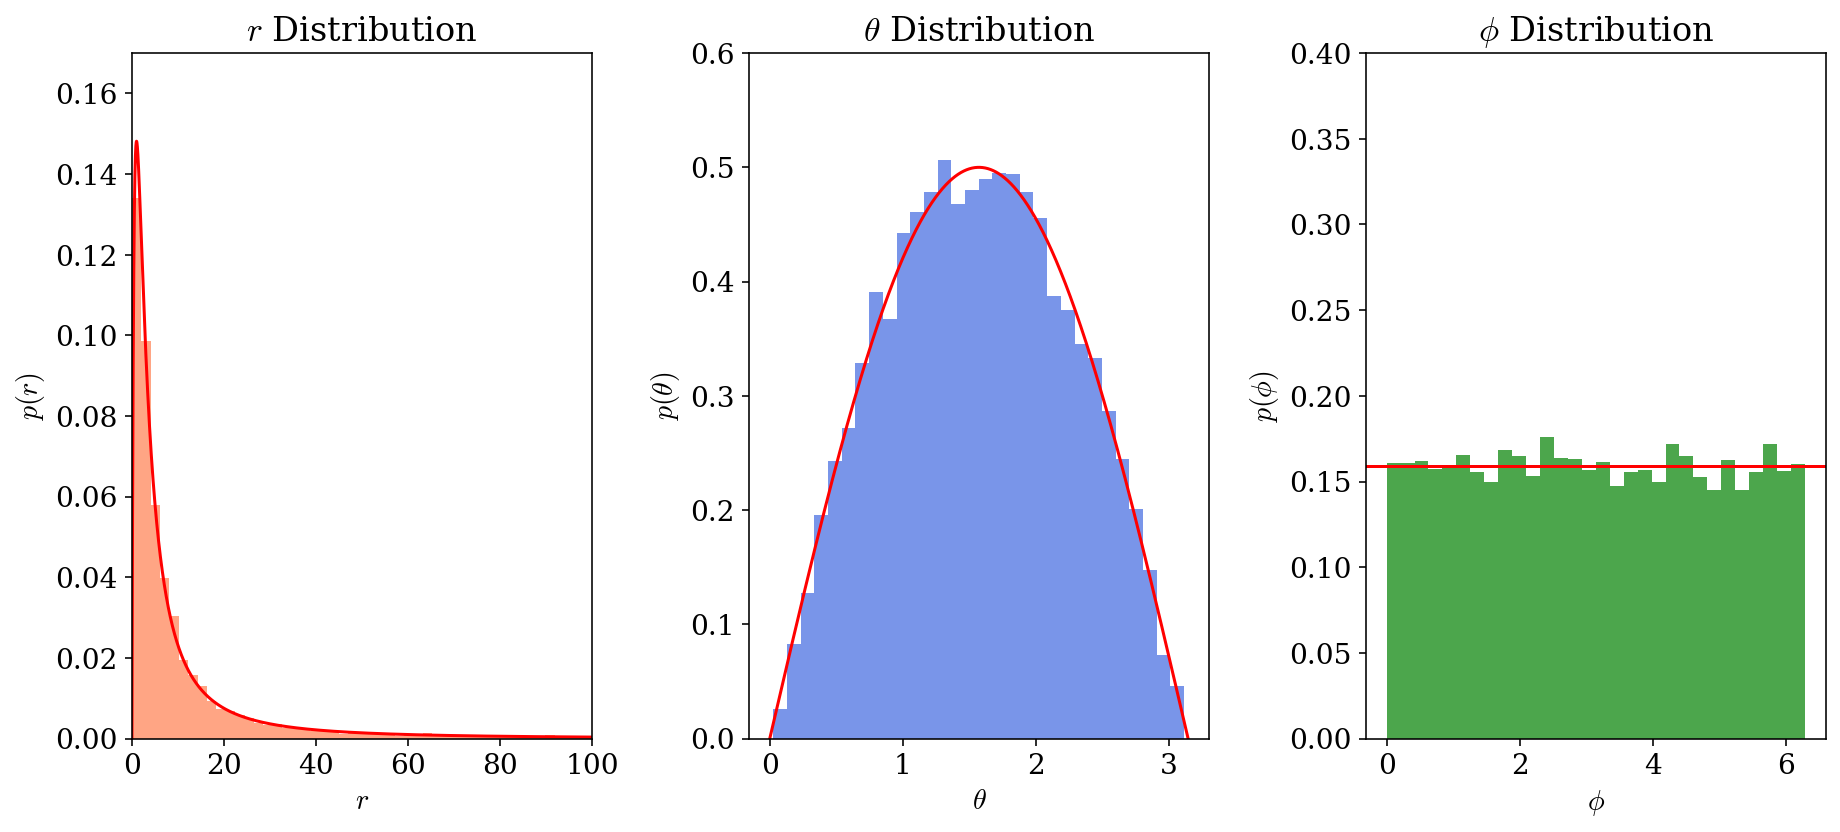

In [4]:
# Plots of the space values distributions

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(13, 6)) 

q1 = np.linspace(0,100,100000)
bins = np.linspace(0, 100, 50) #for visualisation
ax[0].hist(r, bins = bins, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].plot(q1, p_r(q1),color='red')
ax[0].set(xlim=(0,100), ylim = (0,0.17), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

q2 = np.linspace(0,np.pi,100000)
ax[1].hist(θ, bins = 30, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].plot(q2, p_θ(q2),color='red')
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')


q3 = np.linspace(0,2+np.pi,100000)

ax[2].hist(ϕ, bins = 30, color = 'green', density=True, alpha=.7, lw=0)
ax[2].axhline(p_ϕ(),color='red')
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')


plt.show()

We wanyt to study the dynamical friction on the 'test' BH, we want to impose an initial radial distance from the central BH

$$
r_{BH  test} > 3 a,
$$

otherwise its dynamic will be dominated by the interaction with the central BH and we would not be able to study the dynamical friction

In [5]:
r_decrease = np.sort(r)[::-1] # we sort them to be consistet with the generation of velocities

# Extracting the index of the 'test' BH
index = np.random.randint(np.argmax(r_decrease > 3*a), np.argmax(r_decrease < 20*a))  

x = r_decrease * np.cos(ϕ) * np.sin(θ)
y = r_decrease * np.sin(ϕ) * np.sin(θ)
z = r_decrease * np.cos(θ)

# adding the SMBH at the center (0,0,0)

x = np.concatenate(([0], x))
y = np.concatenate(([0], y))
z = np.concatenate(([0], z))

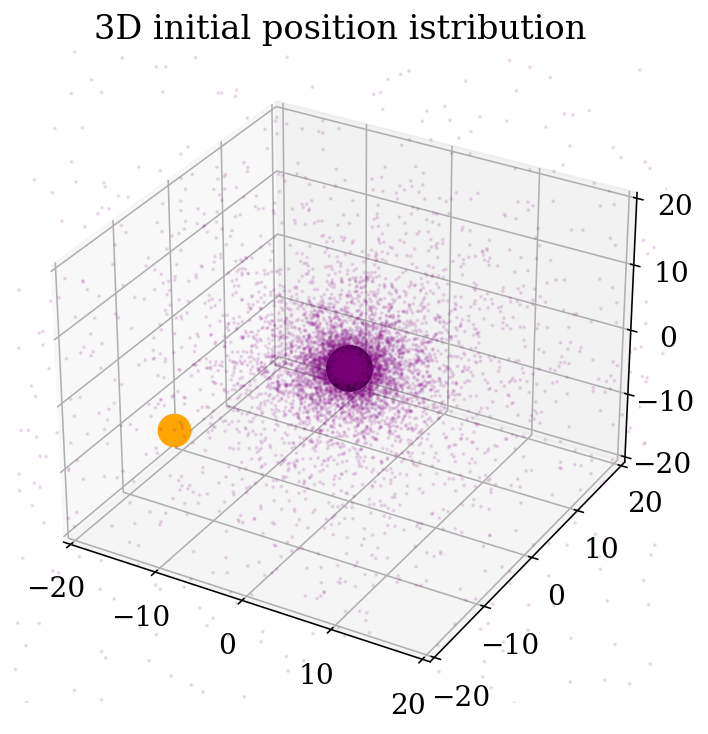

In [6]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d') 
ax.scatter(x, y, z, c = 'purple', s=1, alpha=0.1) 
ax.scatter(x[0], y[0], z[0], c = 'black', s= 0.5*m[0]/m[2])
ax.scatter(x[index+1], y[index+1], z[index+1], c = 'orange', s= 0.5*m[1]/m[2]) 
ax.set_aspect('auto')
ax.set_title('3D initial position istribution')


ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20,20)
plt.show();

In [7]:
# It should be plotted r_decrease[index], not r[index]; I do not correct to not generate a different distribution from the one that I used to run
print('r and (x,y,z) of the test BH:', r[index], x[index+1], y[index+1], z[index+1]) 

r and (x,y,z) of the test BH: 4.7199513183804465 -8.042215047456581 -19.651198235893567 0.8596267126112003


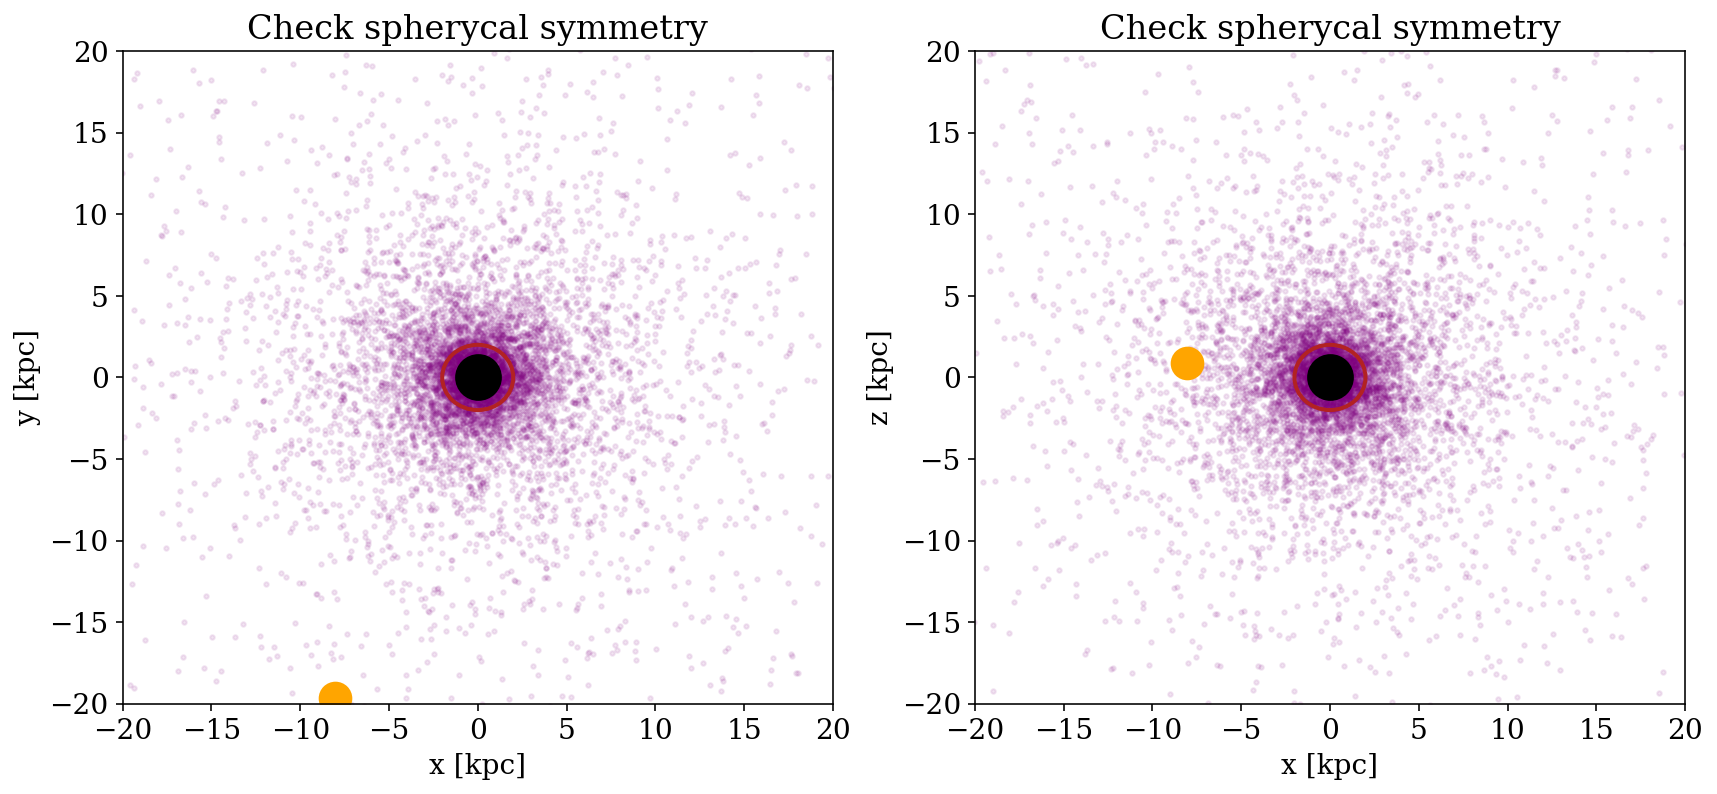

In [8]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

draw_circle_xy = plt.Circle((0,0), a,color='firebrick',fill=False,lw=2)

ax[0].scatter(x,y, c = 'purple', s=5, alpha=0.1) 
ax[0].scatter(x[0], y[0], c = 'black', s= 0.5*m[0]/m[2]) 
ax[0].scatter(x[index+1], y[index+1], c = 'orange', s= 0.5*m[1]/m[2]) 
ax[0].set_title('Check spherycal symmetry')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[0].set_ylim(-20,20)
ax[0].set_xlim(-20,20)
ax[0].add_artist(draw_circle_xy)

draw_circle_xz = plt.Circle((0,0), a,color='firebrick',fill=False,lw=2)

ax[1].scatter(x,z, c = 'purple', s=5, alpha=0.1)
ax[1].scatter(x[0], z[0], c = 'black', s= 0.5*m[0]/m[2]) 
ax[1].scatter(x[index+1], z[index+1], c = 'orange', s= 0.5*m[1]/m[2]) 
ax[1].set_title('Check spherycal symmetry')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[1].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[1].add_artist(draw_circle_xz)

## Generating velocities

https://arxiv.org/pdf/astro-ph/9309044

### Hernquist distribution
We are working with $ G = 1 $ and $ M_{tot} \neq 0 $ , but for the discusssion below we always write the constant for completness. 

The gravitational potential $ \Phi(r) $ is given by : 

$$ \Phi(r) = - \int_r^\infty \frac{M \Phi(r') \, dr'}{{r'}^2}  = -\frac{G M_{tot}}{a+r} \quad . $$ 

We assume that the phase-space distribution function (DF) depends only on energy, which implies that the velocity-dispersion tensor is isotropic. 

Jeans' theorem ensures that any DF that depends only on energy is a steady-state solution of the collisionless Boltzmann equation. $ f \geq 0 $ is the mass per unit volume of phase space.

Let's define some variables: 
- conserved energy (per unit mass) and relative potential $  E = \Phi + \frac{1}{2} v^2, \quad  \Psi = - \Phi + \Phi_{0} ,$
- relative energy (per unit mass) $ \epsilon \equiv -E + \Phi_{0} = \Psi - \frac{1}{2} v^2 $ .

(these quantities are defned so that we work with non-negative variables).

The density $ \rho $ is given by:

$$ \rho = 2^{5/2} \pi \int_0^{\Psi} f(\epsilon) \, (\psi -\epsilon)^{1/2} \, d\epsilon, $$ 

inverting ad obtaining the Eddington's formula

$$ f(\epsilon) = \frac{1}{2^{3/2} \pi^2} \frac{d}{d\epsilon} \left( \int_0^\epsilon \frac{d\rho}{d\psi} \frac{1}{(\epsilon-\psi)^{1/2}} d\psi \right) = \frac{1}{2^{3/2} \pi^2} \int_0^{\epsilon} \frac{d^2 \rho}{d \psi^2} \frac{1}{(\epsilon-\psi)^{1/2}}d\psi. $$ 



### Hernquist distribution with a central BH 
We modified our system including a BH a the center of it.
$$ \Phi^*(r) \equiv \Phi(r)  - \frac{GM_{BH}}{r},$$

therefore 

$$
f(\epsilon) = \frac{1}{2^{3/2} \pi^2} \frac{d}{d\epsilon} \left( \int_0^\epsilon \frac{d\rho}{d\Psi^*} \frac{1}{(\epsilon-\Psi^*)^{1/2}} d\Psi^* \right). 
$$ 



In [9]:
# Potentials

def Φ_H(r): 
    return -M/(r+a)

def Φ_BH(r):
    return -M_BH_central/r

def Φ_tot(r):
    return Φ_H(r) + Φ_BH(r)

#density
def ρ_H(r):
    return M/(2*np.pi) * a/r * 1/(r+a)**3

We do a check of the density distribution, computing $ \rho = (N_{particle} \cdot mass)/dV $ 



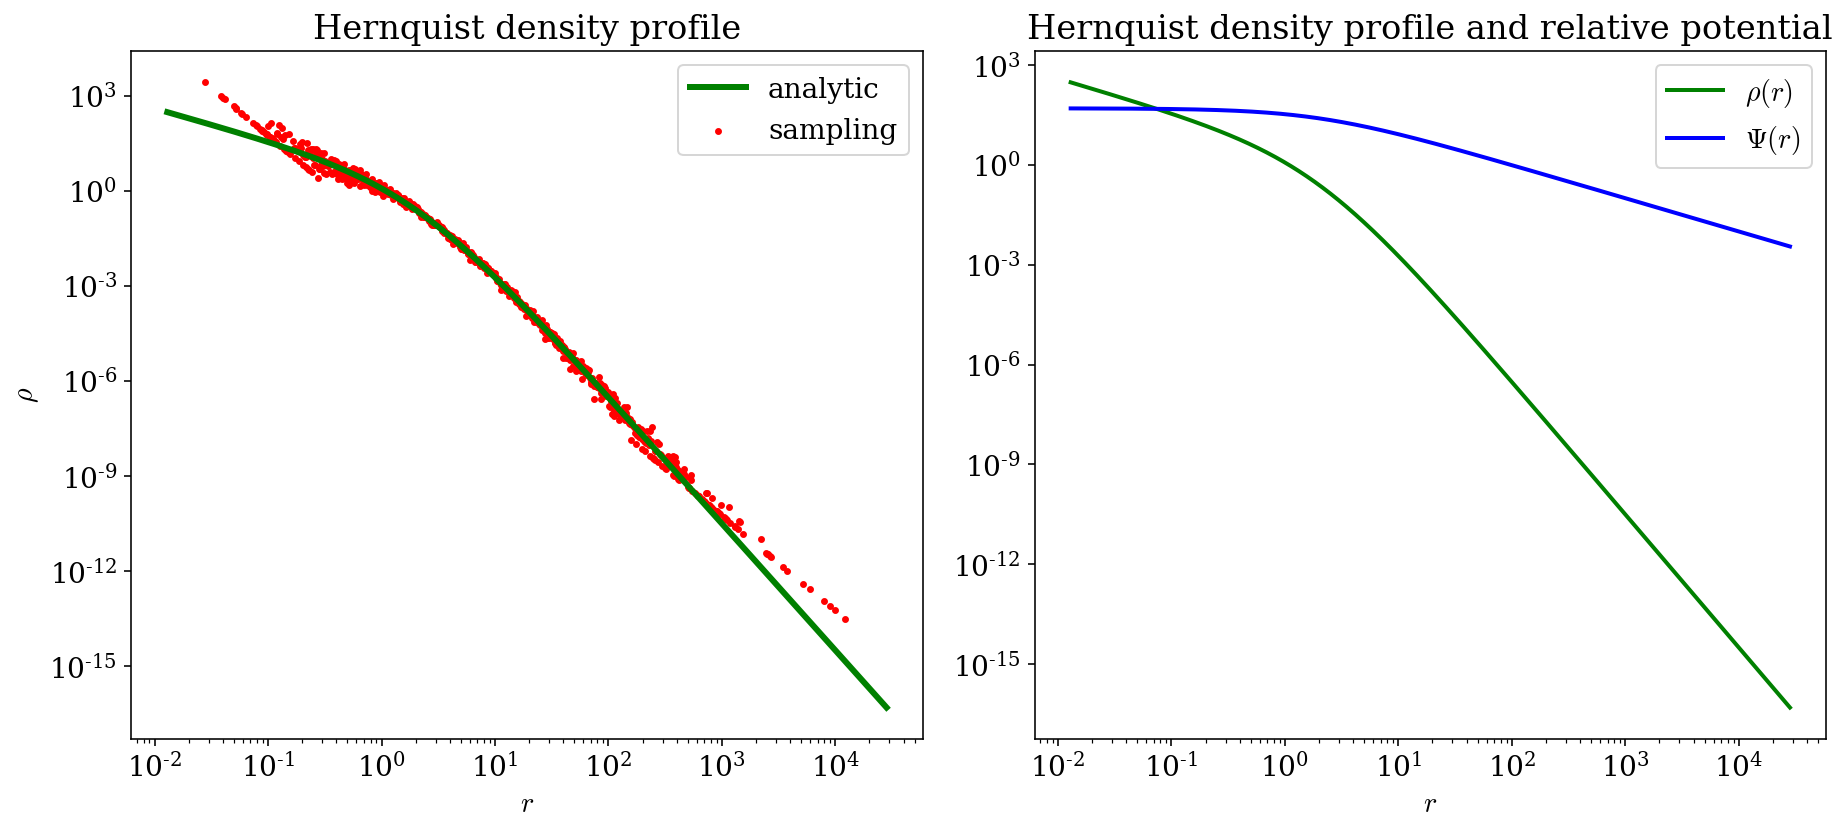

In [10]:
def count_particle(r_g, r_H):
    num_part = []
    for i in range(len(r_g)-1):
        left  = r_g[i]
        right = r_g[i+1]
        n = len([el for el in r_H if (left<el<right)])
        num_part.append(n)
    return num_part


r_grid   = np.geomspace(min(r),max(r),1000)
dV = np.array([(4*np.pi*r_grid[i+1]**3)/3 - (4*np.pi*r_grid[i]**3)/3 for i in range(len(r_grid)-1)])
n_shell = np.array(count_particle(r_grid, np.sort(r)))
density = (n_shell/dV)*mass

density_analytic =  ρ_H(r_grid)

fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(13, 6)) 

ax[0].plot(r_grid, density_analytic, color = 'green', label='analytic', linewidth = 3)
ax[0].scatter(r_grid[1:], density, color = 'red', label='sampling', s = 6)

ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_title('Hernquist density profile')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()


ax[1].plot(r_grid, density_analytic, color = 'green', label=r'$\rho(r)$', linewidth = 2)
ax[1].plot(r_grid,  -Φ_H(r_grid), color = 'blue', label=r'$\Psi(r)$', linewidth = 2)

ax[1].set_xlabel(r'$r$')
ax[1].set_title('Hernquist density profile and relative potential')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

In order to sample the velocities, we need to computer first the DF $ f(\epsilon) $, since there is not an analytic ssolution for our system, Hernquist + a central BH, we proceed numerically.

Starting from the integral 

$$
J(\epsilon) =  \int_0^\epsilon \frac{d\rho}{d\Psi^*} \frac{1}{(\epsilon-\Psi^*)^{1/2}} d\Psi^*  \,,
$$

The extreme of integration $\varepsilon$ runs between $0$ and the maximum value of the potential (that is given by the value of the relative potential at the centre of the distribution). 

To compute numerically the integral we build an array of $\varepsilon$ over which valuate the integral: $\varepsilon \in [0,\Psi^*(r=0)]$. 

In order to have the arrays running in the same radial direction as $\varepsilon$ (from $r=\infty$ to $r=0$), we order the $\rho$ and $\psi$ array according to this.



In [11]:
# define the extreme of integration for each particle according to its radius (the max value is psi)
eps_integral = -Φ_tot(r_decrease)  

# define the approximation of the integral
alpha = 0.999999999
integral = np.zeros(N)

for i in range(N):
    N_int = 100
    
    r_ = np.linspace(r_decrease[0]+1,r_decrease[i],N_int)
    Ψ = -Φ_tot(r_)
    ρ = ρ_H(r_)
    
    drho_dpsi = np.gradient(ρ)/np.gradient(Ψ)
    
    integral[i] = np.trapz(drho_dpsi/(np.sqrt(eps_integral[i]-alpha*Ψ)),Ψ)
    

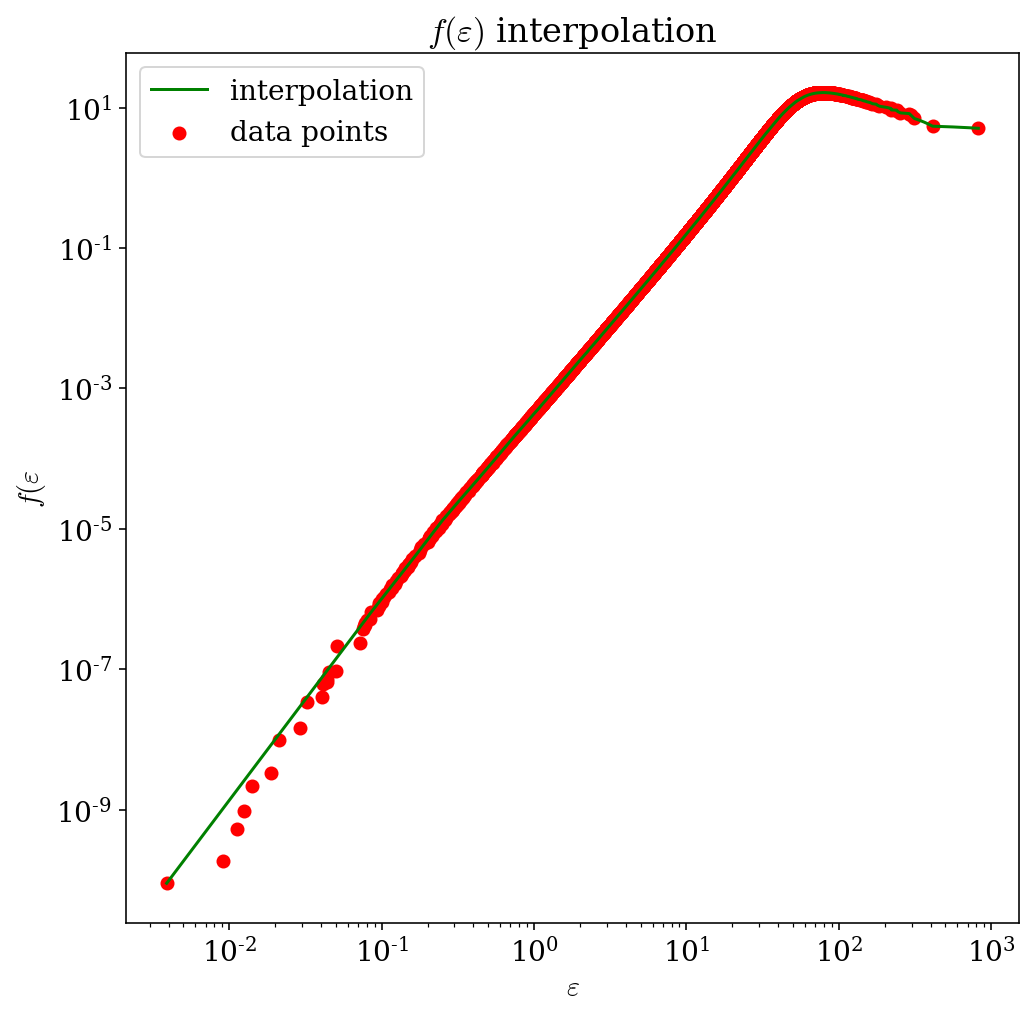

In [12]:
f_eps = 1/(np.sqrt(8)*np.pi**2)*np.gradient(integral)/np.gradient(eps_integral)

# interpolation of the f(eps)
f_eps_interpolate = scipy.interpolate.interp1d(eps_integral,f_eps,kind='linear')

eps_grid = np.linspace(min(eps_integral),max(eps_integral),N)

fig = plt.figure(figsize=(8,8))

plt.plot(eps_grid,f_eps_interpolate(eps_grid),color='green',label='interpolation')
plt.scatter(eps_integral,f_eps,label='data points', color = 'red')
plt.loglog()
plt.title(r'$f(\varepsilon)$ interpolation')
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$f(\varepsilon$')

plt.legend()

In order to do determine the velocity distribution numerically, we need to integrate the distribution function over the velocity space:

$$ F(\varepsilon) = \int f(\varepsilon)d^3v $$

but under the assumption of isotropic distribution of velocities, the integral becomes:

$$ F(\varepsilon) = 4\pi \int_0^v f(\varepsilon) v^2 dv $$

From the definition of $\varepsilon = \psi - \frac{v^2}{2}$, we can write:

$$ v= \sqrt{2(\psi - \varepsilon)} $$ 

So the integral becomes:

$$ F(\varepsilon) = 4 \pi \int_0^{\psi} d\varepsilon  f(\varepsilon) \sqrt{2(\psi - \varepsilon)}   $$

Once we have computed numerically the integral for $F(\varepsilon)$ we can think to invert it to get the velocity distribution. The first step to achieve this goal is to normalize the integral:

$$ F_{norm}(\varepsilon) = \frac{F(\varepsilon)}{max(F)}$$

In this way this $ F_{norm}(\varepsilon)$ is a quantity within $(0,1)$. As already discussed, $\varepsilon = \psi - \frac{v^2}{2}$ and therefore the sampliing of the velocity distribution is not strightforward, since for each radius $\varepsilon$ runs from $0$ to $\psi(r)$. 

We adopt the **inverse sampling** method: we sample some values $ u $ from a uniform distribution $\mathcal{U}(0, 1) $
and find which is the value of $\varepsilon$ that minimizes $ | F(\epsilon) - u | $ . In this way we have fixed both $\psi$ and $\varepsilon$ and we are able to extract the velocity distribution.

In [13]:
N_F = 100
v_H = np.zeros(N)
psi_F = -Φ_tot(r_decrease)  
F_eps = np.zeros(N)
eps_distr = np.zeros(N)
for k in tqdm(range(N)):
    # define the value of psi at a given radius
    epsilon_F = np.linspace(min(eps_integral),psi_F[k],N_F) # define eps running in (0,psi(r))
    integral_F = np.empty(N_F)
    
    f_eps_j = f_eps_interpolate(epsilon_F) # evaluating the distribution function
    for i in range(N_F): # compute the numerical integral of F for each epsilon
        integral_F[i] = np.trapz(4*np.pi * np.sqrt(2*(psi_F[k] - epsilon_F[epsilon_F<=epsilon_F[i]])) *  f_eps_j[epsilon_F<=epsilon_F[i]],epsilon_F[epsilon_F<=epsilon_F[i]])
    
    
    if(k == 0):   
        eps_distr[0] = 0
        v_H[0] = 0
        F_eps[0] += 0
    else:
        F_norm = integral_F/max(integral_F)  # F_norm is whithin (0,1)        
        inv_interp_F = scipy.interpolate.interp1d(F_norm,epsilon_F,kind='linear')
    
        F_sample = np.random.uniform(0,1)    # to sample the correct eps
        eps_sample = inv_interp_F(F_sample)  # to find the epsilon giving the value of F
        eps_distr[k] = eps_sample
        v_H[k] = np.sqrt(2*(psi_F[k]-eps_sample))
    
        F_eps[k] += integral_F[-1]

100%|███████████████████████████████████████████████████████████████████████████| 10001/10001 [00:51<00:00, 193.68it/s]


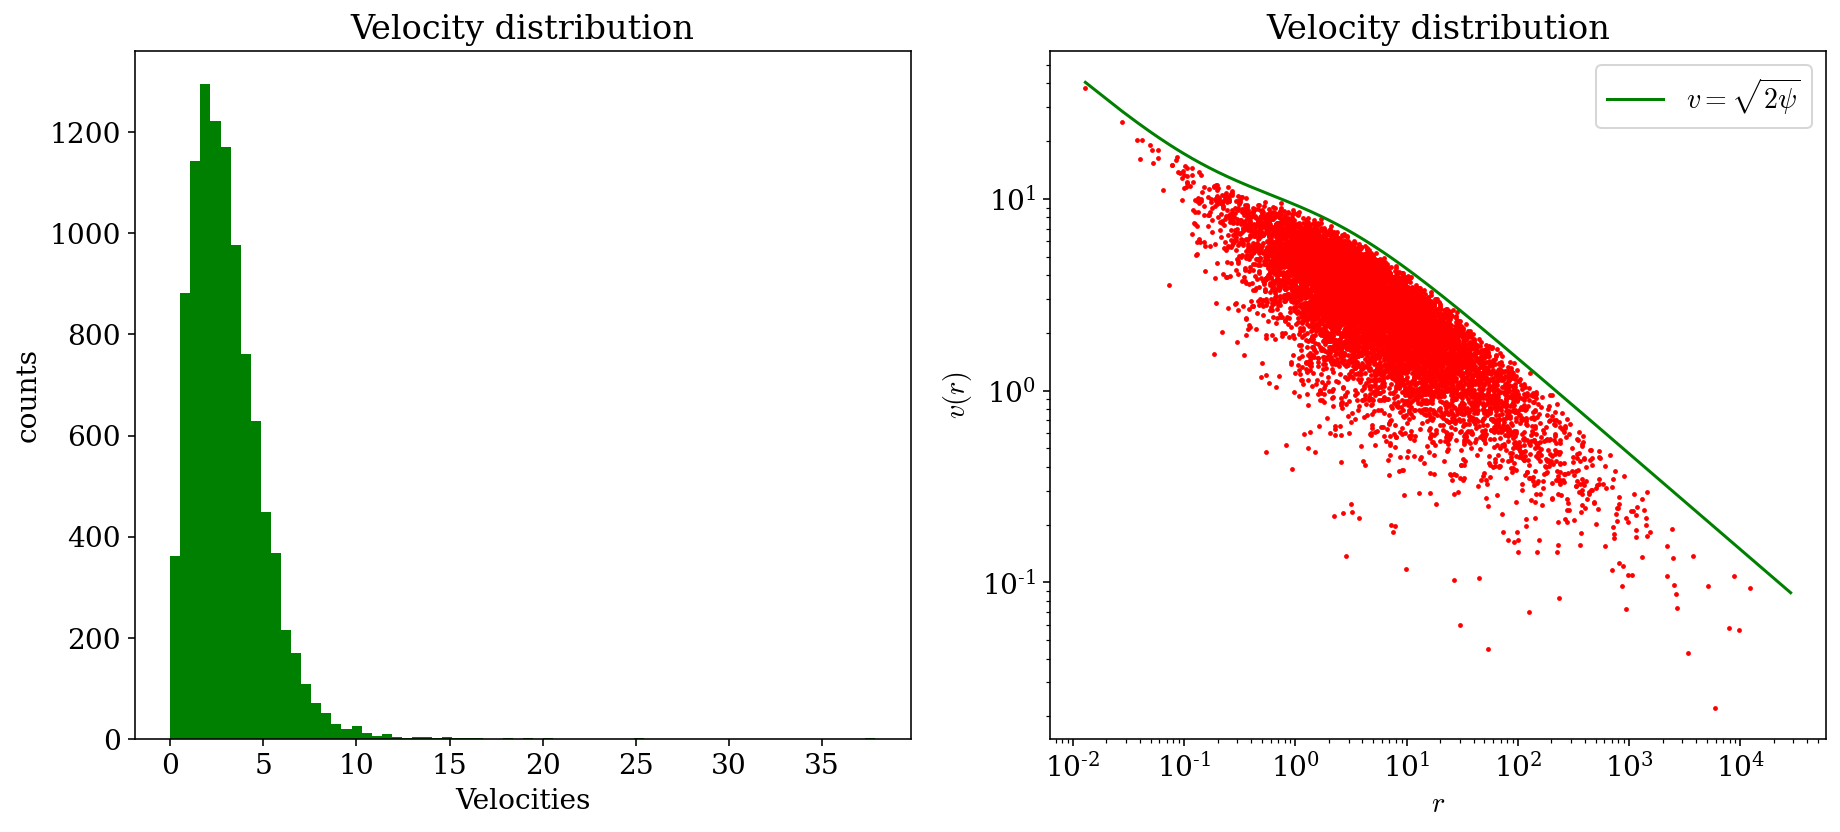

In [14]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(13, 6)) 

ax[0].hist(v_H,bins=70, color = 'green')

ax[0].set_xlabel('Velocities')
ax[0].set_ylabel('counts')
ax[0].set_title('Velocity distribution')



ax[1].plot(r_decrease,np.sqrt(2*abs(Φ_tot(r_decrease))),color='green',label=r'$v=\sqrt{2\psi}$')
ax[1].scatter(r_decrease,v_H,s=2, color = 'red')

ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$v(r)$')
ax[1].set_title('Velocity distribution')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()



In [15]:
θ_2 = θ_sample()
ϕ_2 = ϕ_sample()

v_x = v_H * np.sin(θ_2) * np.cos(ϕ_2)
v_y = v_H * np.sin(θ_2) * np.sin(ϕ_2)
v_z = v_H * np.cos(θ_2)

# adding the SMBH with v=(0,0,0)

v_x = np.concatenate(([0], v_x))
v_y = np.concatenate(([0], v_y))
v_z = np.concatenate(([0], v_z))

In [16]:
print('(vx,vy,vz) of the BH_df:', v_x[index+1], v_y[index+1], v_z[index+1])

(vx,vy,vz) of the BH_df: 1.8529206556027231 1.413949955116661 0.2067334398101042


In [17]:
# For the seek of semplicity we put in the second position, index = 1 the 'test' BH

x[1], x[index+1] = x[index+1], x[1]
y[1], y[index+1] = y[index+1], y[1]
z[1], z[index+1] = z[index+1], z[1]

v_x[1], v_x[index+1] = v_x[index+1], v_x[1]
v_y[1], v_y[index+1] = v_y[index+1], v_y[1]
v_z[1], v_z[index+1] = v_z[index+1], v_z[1]

In [18]:
print(x[0],y[0],z[0])
print(v_x[0],v_y[0],v_z[0])

0.0 0.0 0.0
0.0 0.0 0.0


## Input file

In [19]:
dim = 3

with open ('initial_conditions_N10000_a3.txt', 'w+') as f:
    f.write(str(N_tot) +'\n')
    f.write(str(dim) + '\n')
    f.write(str(t_init)+'\n')
    for m_i in m:
        f.write(f'{m_i}' + '\n')
    for i in range(N_tot):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N_tot):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')
    
f.close()



## Parameters for the simulations 

In [20]:
avg_rho = (ρ_H(a)) # to compute the dynamical time

print('rho_a =',avg_rho)

# initialize treecode parameters

theta_tc = 0.1
T_dyn = np.sqrt((3*np.pi)/(16*avg_rho))

t_stop = 10*T_dyn
t_step = 0.01*T_dyn
t_out = 0.1*T_dyn
eps = (4/3*np.pi*a**3/len(np.where(np.sort(r)<a)[0]))**(1/3)*10**(-2)
print('theoretical eps:',eps)
eps = 0.3

sigma_vz = np.std(v_z[1:][r_decrease<a])
infl_radius = M_BH_central/(sigma_vz**2)

print('radius of 10% of the total mass (IU):',R_P(0.1))
print('scale radius (IU):',a)
print('BH influence radius:',infl_radius)
print('T_dyn =',T_dyn)
print('theta = ',theta_tc)
print('t_step = ',t_step)
print('t_out = ',t_out)
print('t_stop = ',t_stop)
print('epsilon = ',eps)

rho_a = 0.24867959858108646
theoretical eps: 0.002349124402411446
radius of 10% of the total mass (IU): 0.9249505911485288
scale radius (IU): 2
BH influence radius: 1.0323018889123496
T_dyn = 1.539059796194237
theta =  0.1
t_step =  0.01539059796194237
t_out =  0.1539059796194237
t_stop =  15.390597961942369
epsilon =  0.3


## Reading results

### Output file

In [3]:
file = open('output_file_N10000_a3_eps03_tstop150.txt', "r")
firstrow = (file.readline()).strip("\n")
NL = 1
for line in file:
    NL += 1
file.close()

#                                # More info below, at lines 94-101
I = int(firstrow)				# N_particles
L = 3+3*I						# N_lines for each timestep
NT = int(NL / L)				# N_timesteps
X = np.zeros((I,4,NT))			# Empty array for the positions at each t
V = np.zeros((I,4,NT))			# Empty array for the velocities at each t
#P = np.zeros((I,NT))			# Empty array for the potentials at each t
#K = np.zeros((I,NT))			# Empty array for the kinetic energies at each t
#E = np.zeros((I,NT))			# Empty array for the energies at each t
M = np.zeros((I,NT))			# Empty array for the masses at each t (should be const)
N = np.zeros(NT)				# Empty array for the N_particles at each t (should be const)
Time = np.zeros(NT)				# Empty array for the times t


file = open('output_file_N10000_a3_eps03_tstop150.txt', "r") # Read data
i = 0
t = 0
for line in file:
	a = line.strip("\n")
	j = i % L
	if j == 0:
		N[t] = float(a)
	elif j == 2:
		Time[t] = float(a)
	elif j >= 3 and j < (3+I): 
		m = j-3
		M[m,t] = float(a)
	elif j >= (3+I) and j < (3+2*I):
		m = j - (3+I)
		b = a.split()
		for k in range(len(b)):
			X[m,k+1,t] = float(b[k])
	elif j >= (3+2*I) and j < (3+3*I):
		m = j - (3+2*I)
		b = a.split()
		for k in range(len(b)):
			V[m,k+1,t] = float(b[k])
#	elif j >= (3+3*I) and j < (3+4*I):
#		m = j - (3+3*I)
#		P[m,t] = float(a)
		if (j+1) == (3+3*I):
			t += 1
	i += 1
file.close()


In [4]:
# fill the array
t_sim = Time

masses = M.T

x_sim = X.T[:,1,:]
y_sim = X.T[:,2,:]
z_sim = X.T[:,3,:]

Vx_sim = V.T[:,1,:]
Vy_sim = V.T[:,2,:]
Vz_sim = V.T[:,3,:]

In [5]:
r_sim = np.sqrt(x_sim**2 + y_sim**2 + z_sim**2)

### Log file

In [6]:
logname = 'logfile_N10000_a3_eps03_tstop150.txt'
dt,d_tout,final_t = np.genfromtxt(logname,skip_header=4,usecols=(1,5,6),unpack=True,max_rows=1)
print('printing timestep: ',dt,'d_tout: ',d_tout,' final time: ',final_t)

N_out = int(final_t/d_tout) # number of times the sys is printed during the simulation
N_print = int(final_t/dt) # compute the number of prints of the system status
N_in_out = int(d_tout/dt)

# Function to find the numbers of lines containing the word 'data'
def find_lines_with_word(filename, word):
    line_numbers = []
    with open(filename, 'r') as file:
        for line_num, line in enumerate(file, start=1):
            if word in line:
                line_numbers.append(line_num)
    return line_numbers

word_to_find = 'data'
line_numbers = np.array(find_lines_with_word(logname, word_to_find))

printing timestep:  0.0015 d_tout:  1.5  final time:  150.0


In [7]:
time = []
E_tot = []
T = []
U = []
T_over_U = []
V_com = []
L_tot = []

# Function to separate concatened numbers
def parse_line(line):
    point_index = line.find('.')
    part1 = line[:point_index+4] 
    part2 = line[point_index+4:]
    part2 = re.sub(r'(\d+\.\d{5})', r'\1 ', part2)
    result = part1 + ' ' + part2
    return result.split()
with open(logname, 'r') as file:
    lines = file.readlines()

for i, line in enumerate(lines[10:11]):  
    cols = parse_line(line)
    if len(cols) >= 7:  # to be sure there are at least seven columns
        time.append(float(cols[0]))
        E_tot.append(float(cols[1]))
        T.append(float(cols[2]))
        U.append(float(cols[3]))
        T_over_U.append(float(cols[4]))
        V_com.append(float(cols[5]))
        L_tot.append(float(cols[6]))

        
line_step = 6  
first_out = 13

for j in range(N_out):
    init_line_out = line_numbers[j]
    for i in range(0,N_in_out):
        init_skip = init_line_out + 5
        skip_line = (i) * line_step + init_skip
        cols = parse_line(lines[skip_line])
        if len(cols) >= 7:  
            time.append(float(cols[0]))
            E_tot.append(float(cols[1]))
            T.append(float(cols[2]))
            U.append(float(cols[3]))
            T_over_U.append(float(cols[4]))
            V_com.append(float(cols[5]))
            L_tot.append(float(cols[6]))

time = np.array(time)
E_tot = np.array(E_tot)
T = np.array(T)
U = -np.array(U)
T_over_U = np.array(T_over_U)
V_com = np.array(V_com)
L_tot = np.array(L_tot)



## Animation

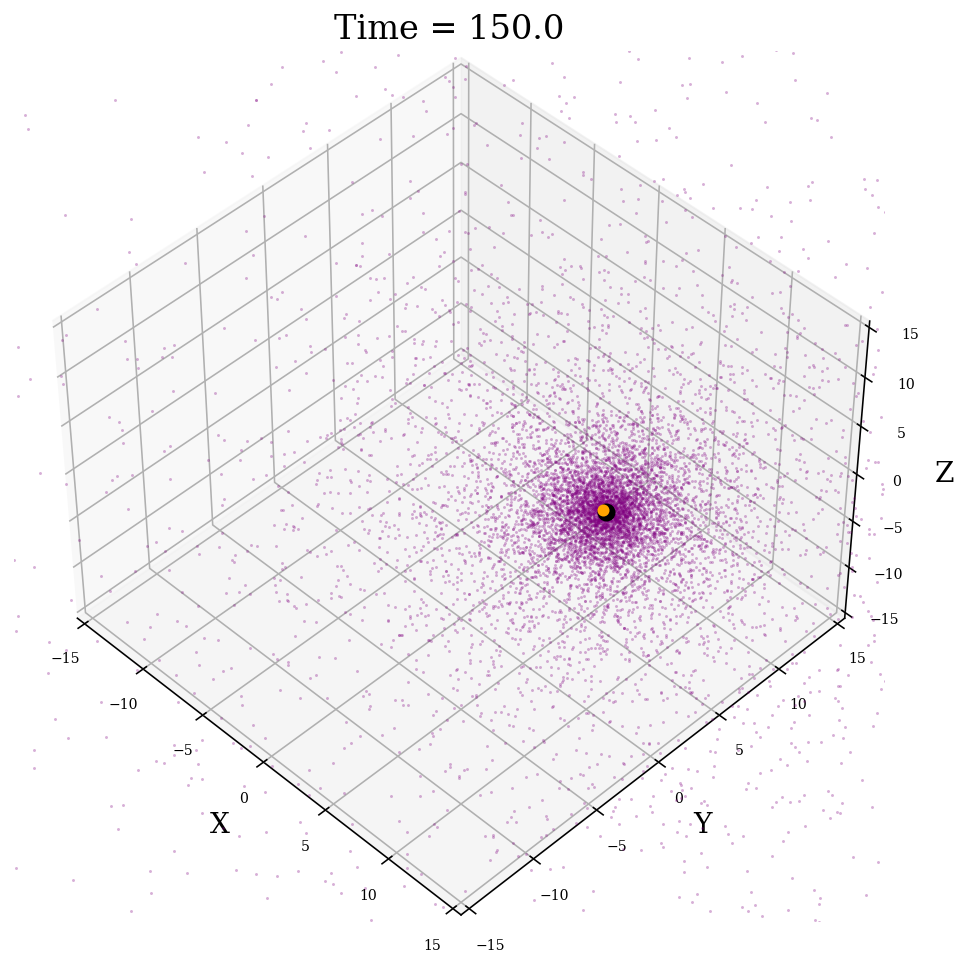

In [8]:
fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('auto')

# compute the center of mass for visualization:
com_x = np.sum(masses[0,:]*x_sim[0,:])/(M+M_BH_central+M_BH_df)
com_y = np.sum(masses[0,:]*y_sim[0,:])/(M+M_BH_central+M_BH_df)
com_z = np.sum(masses[0,:]*z_sim[0,:])/(M+M_BH_central+M_BH_df)

ax.view_init(elev=45, azim=-45)
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_zlim(-15,15)

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')
ax.set_zlabel(r'Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

scatters, = ax.plot([], [], [], 'o', markersize='0.5',alpha=0.3, color = 'purple')
scatter_BH_central, = ax.plot([], [], [], 'o', markersize='8',color='black')
scatter_BH_df, = ax.plot([], [], [], 'o', markersize='5',color='orange')


def init():
    scatters.set_data([],[])
    scatters.set_3d_properties([])
    
    scatter_BH_central.set_data([],[])
    scatter_BH_central.set_3d_properties([])
    
    scatter_BH_df.set_data([],[])
    scatter_BH_df.set_3d_properties([])
    
    return scatters, scatter_BH_central, scatter_BH_df

def animate_time(i): 
    # plot the Hernquist distribution
    scatters.set_data(x_sim[i,2:], y_sim[i,2:]) 
    scatters.set_3d_properties(z_sim[i,2:])
    
    # plot the central BH
    scatter_BH_central.set_data(np.array([x_sim[i,0]]), np.array([y_sim[i,0]]))
    scatter_BH_central.set_3d_properties(np.array([z_sim[i,0]]))
    
    # plot the cengtral 'test' BH
    scatter_BH_df.set_data(np.array([x_sim[i,1]]), np.array([y_sim[i,1]]))
    scatter_BH_df.set_3d_properties(np.array([z_sim[i,1]]))
    
    ax.set_title('Time = %.1f'%(t_sim[i]))
        
    return scatters, scatter_BH_central, scatter_BH_df


num_frames = len(t_sim)
animazione = FuncAnimation(fig, animate_time, frames=num_frames, interval=100, init_func=init)

# save gif ----------------------------------------------------------------------------------------

animazione.save('Hernquist_a3_N10000_eps03_tstop150.gif', writer = 'ffmpeg')

plt.rcParams['animation.html'] = 'html5'

#animazione

# save mp4 ----------------------------------------------------------------------------------------

mywriter = FFMpegWriter()
animazione.save('Hernquist_a3_N10000_eps03_tstop150.mp4',writer=mywriter)

In [9]:
video_path = "Hernquist_a3_N10000_eps03_tstop150.mp4"
HTML(f"""
<video width="640" height="480" controls>
    <source src="{video_path}" type="video/mp4">
    Your browser does not support the video tag.
</video>
""")

## Data Analysis

We reset some constants 

In [216]:
N_H = 10000 # number of particle of the Hernquist distribution
N = N_H + 1 # number of particle included the 'test' BH 
N_tot = N +1 # number of particle included the 'test' BH and the central BH

t_init = 0 # initial time
M = 100 # total mass of the Hernquist system 10^10 Msun

a = 2 # Scale parameter, 2 kpc 

mass = M/N_H # mass of the single particle

M_BH_central = 10 # mass of the central SMBH 10^9 Msun
M_BH_df = 5 # BH where to study the dynamical friction



In [239]:
# Print of the BHs positions
print('Initial r and (x,y,z) of the central BH:', r_sim[0][0], x_sim[0][0], y_sim[0][0], z_sim[0][0]) 
print('Initial r and (x,y,z) of the test BH:', r_sim[0][1], x_sim[0][1], y_sim[0][1], z_sim[0][1])

Initial r and (x,y,z) of the central BH: 0.0 0.0 0.0 0.0
Initial r and (x,y,z) of the test BH: 21.250546546969293 -8.0422153 -19.651197 0.85962671


### Center of Mass (CoM)

The initial sudden jump of the center of mass is likely attributable to the motion of the test black hole as it reaches the center of the system.

Text(0.5, 1.0, 'Centre of Mass')

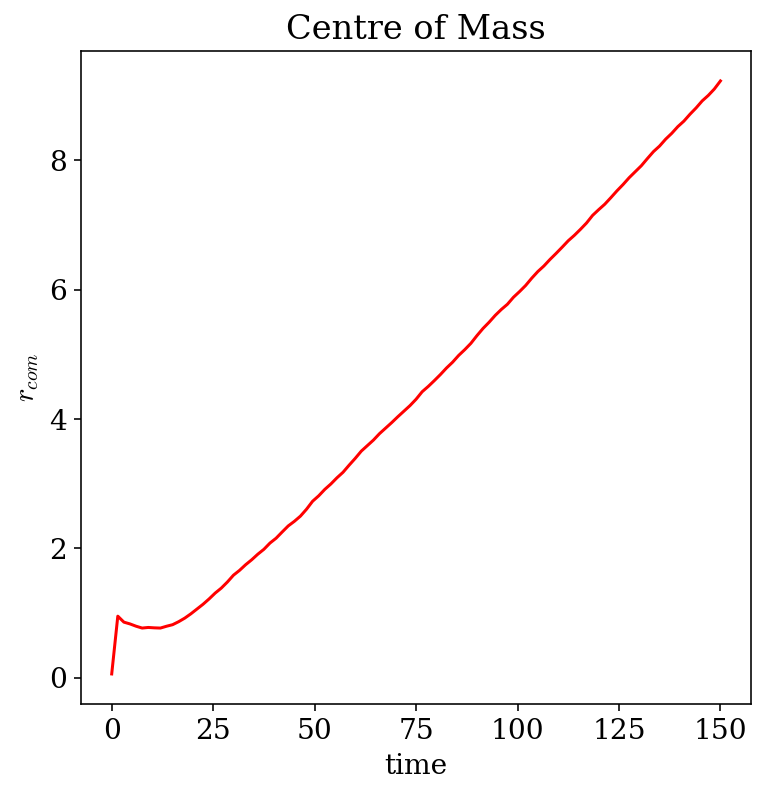

In [217]:
com_x_sim = np.zeros(len(t_sim))
com_y_sim = np.zeros(len(t_sim))
com_z_sim = np.zeros(len(t_sim))
com_r_sim = np.zeros(len(t_sim))

# initial centre of mass
mask_COM_0 = r_sim[0,:]<7*a

com_x_sim[0] = np.sum(x_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))
com_y_sim[0] = np.sum(y_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))
com_z_sim[0] = np.sum(z_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))

com_r_sim[0] = np.sqrt(com_x_sim[0]**2+com_y_sim[0]**2+com_z_sim[0]**2)

for i in range(1,len(t_sim)):
    mask_COM = r_sim[i,:]<10*(com_r_sim[i-1]+a) # to take into account the motion of the centre of mass

    com_x_sim[i] = np.sum(x_sim[i,mask_COM]*masses[i,mask_COM])/(np.sum(masses[i,mask_COM])) # x COM
    com_y_sim[i] = np.sum(y_sim[i,mask_COM]*masses[i,mask_COM])/(np.sum(masses[i,mask_COM])) # y COM
    com_z_sim[i] = np.sum(z_sim[i,mask_COM]*masses[i,mask_COM])/(np.sum(masses[i,mask_COM])) # z COM

    com_r_sim[i] = np.sqrt(com_x_sim[i]**2 + com_y_sim[i]**2 + com_z_sim[i]**2)


fig = plt.subplots(figsize=(6,6))

plt.plot(t_sim,com_r_sim,c='red')
plt.xlabel('time')
plt.ylabel(r'$r_{com}$')
plt.title('Centre of Mass')

Text(0, 0.5, 'z')

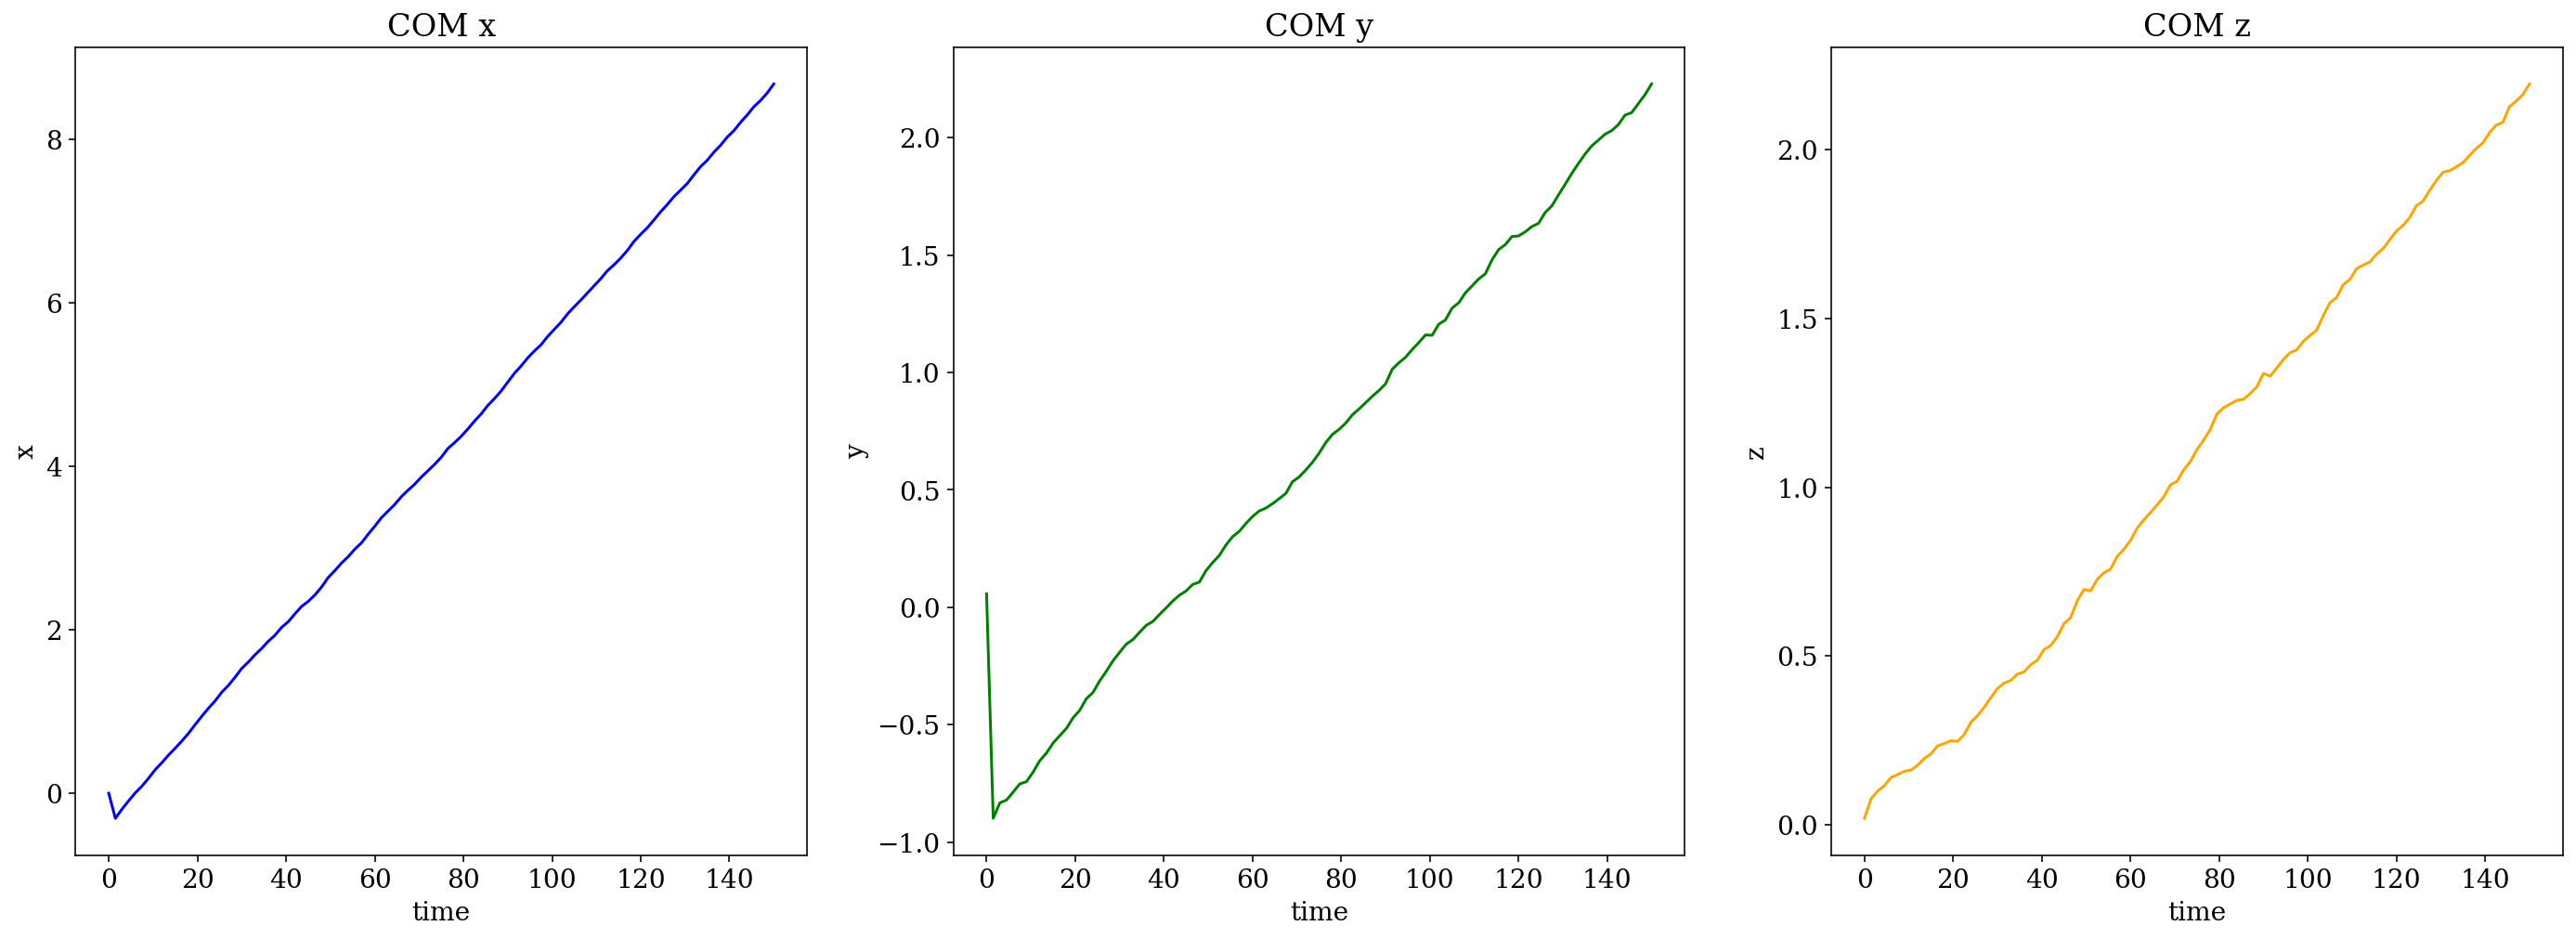

In [218]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(24,8))
ax[0].plot(t_sim,com_x_sim,c='blue')
ax[0].set_title('COM x')
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[1].plot(t_sim,com_y_sim,c='green')
ax[1].set_title('COM y')
ax[1].set_xlabel('time')
ax[1].set_ylabel('y')
ax[2].plot(t_sim,com_z_sim,c='orange')
ax[2].set_title('COM z')
ax[2].set_xlabel('time')
ax[2].set_ylabel('z')

In [219]:
# velocities of the CoM
com_Vx_sim = np.gradient(com_x_sim)/np.gradient(t_sim)
com_Vy_sim = np.gradient(com_y_sim)/np.gradient(t_sim)
com_Vz_sim = np.gradient(com_z_sim)/np.gradient(t_sim)

We decide to work always in the CoM reference frame, so we transform our variables

In [220]:
# move all the particles to the centre of mass

x_sim_COM = np.empty([len(t_sim),N_tot])
y_sim_COM = np.empty([len(t_sim),N_tot])
z_sim_COM = np.empty([len(t_sim),N_tot])

Vx_sim_COM = np.empty([len(t_sim),N_tot])
Vy_sim_COM = np.empty([len(t_sim),N_tot])
Vz_sim_COM = np.empty([len(t_sim),N_tot])

for i in range(len(t_sim)):
    for j in range(N_tot): 
        x_sim_COM[i,j] = x_sim[i,j] - com_x_sim[i]
        y_sim_COM[i,j] = y_sim[i,j] - com_y_sim[i]
        z_sim_COM[i,j] = z_sim[i,j] - com_z_sim[i]
        
        Vx_sim_COM[i,j] = Vx_sim[i,j] - com_Vx_sim[i]
        Vy_sim_COM[i,j] = Vy_sim[i,j] - com_Vy_sim[i]
        Vz_sim_COM[i,j] = Vz_sim[i,j] - com_Vz_sim[i]
        
r_sim_COM = np.sqrt(x_sim_COM**2 + y_sim_COM**2 + z_sim_COM**2)
Vr_sim_COM = np.sqrt(Vx_sim_COM**2 + Vy_sim_COM**2 + Vz_sim_COM**2)

### Motion of the two BH in the CoM reference frame 

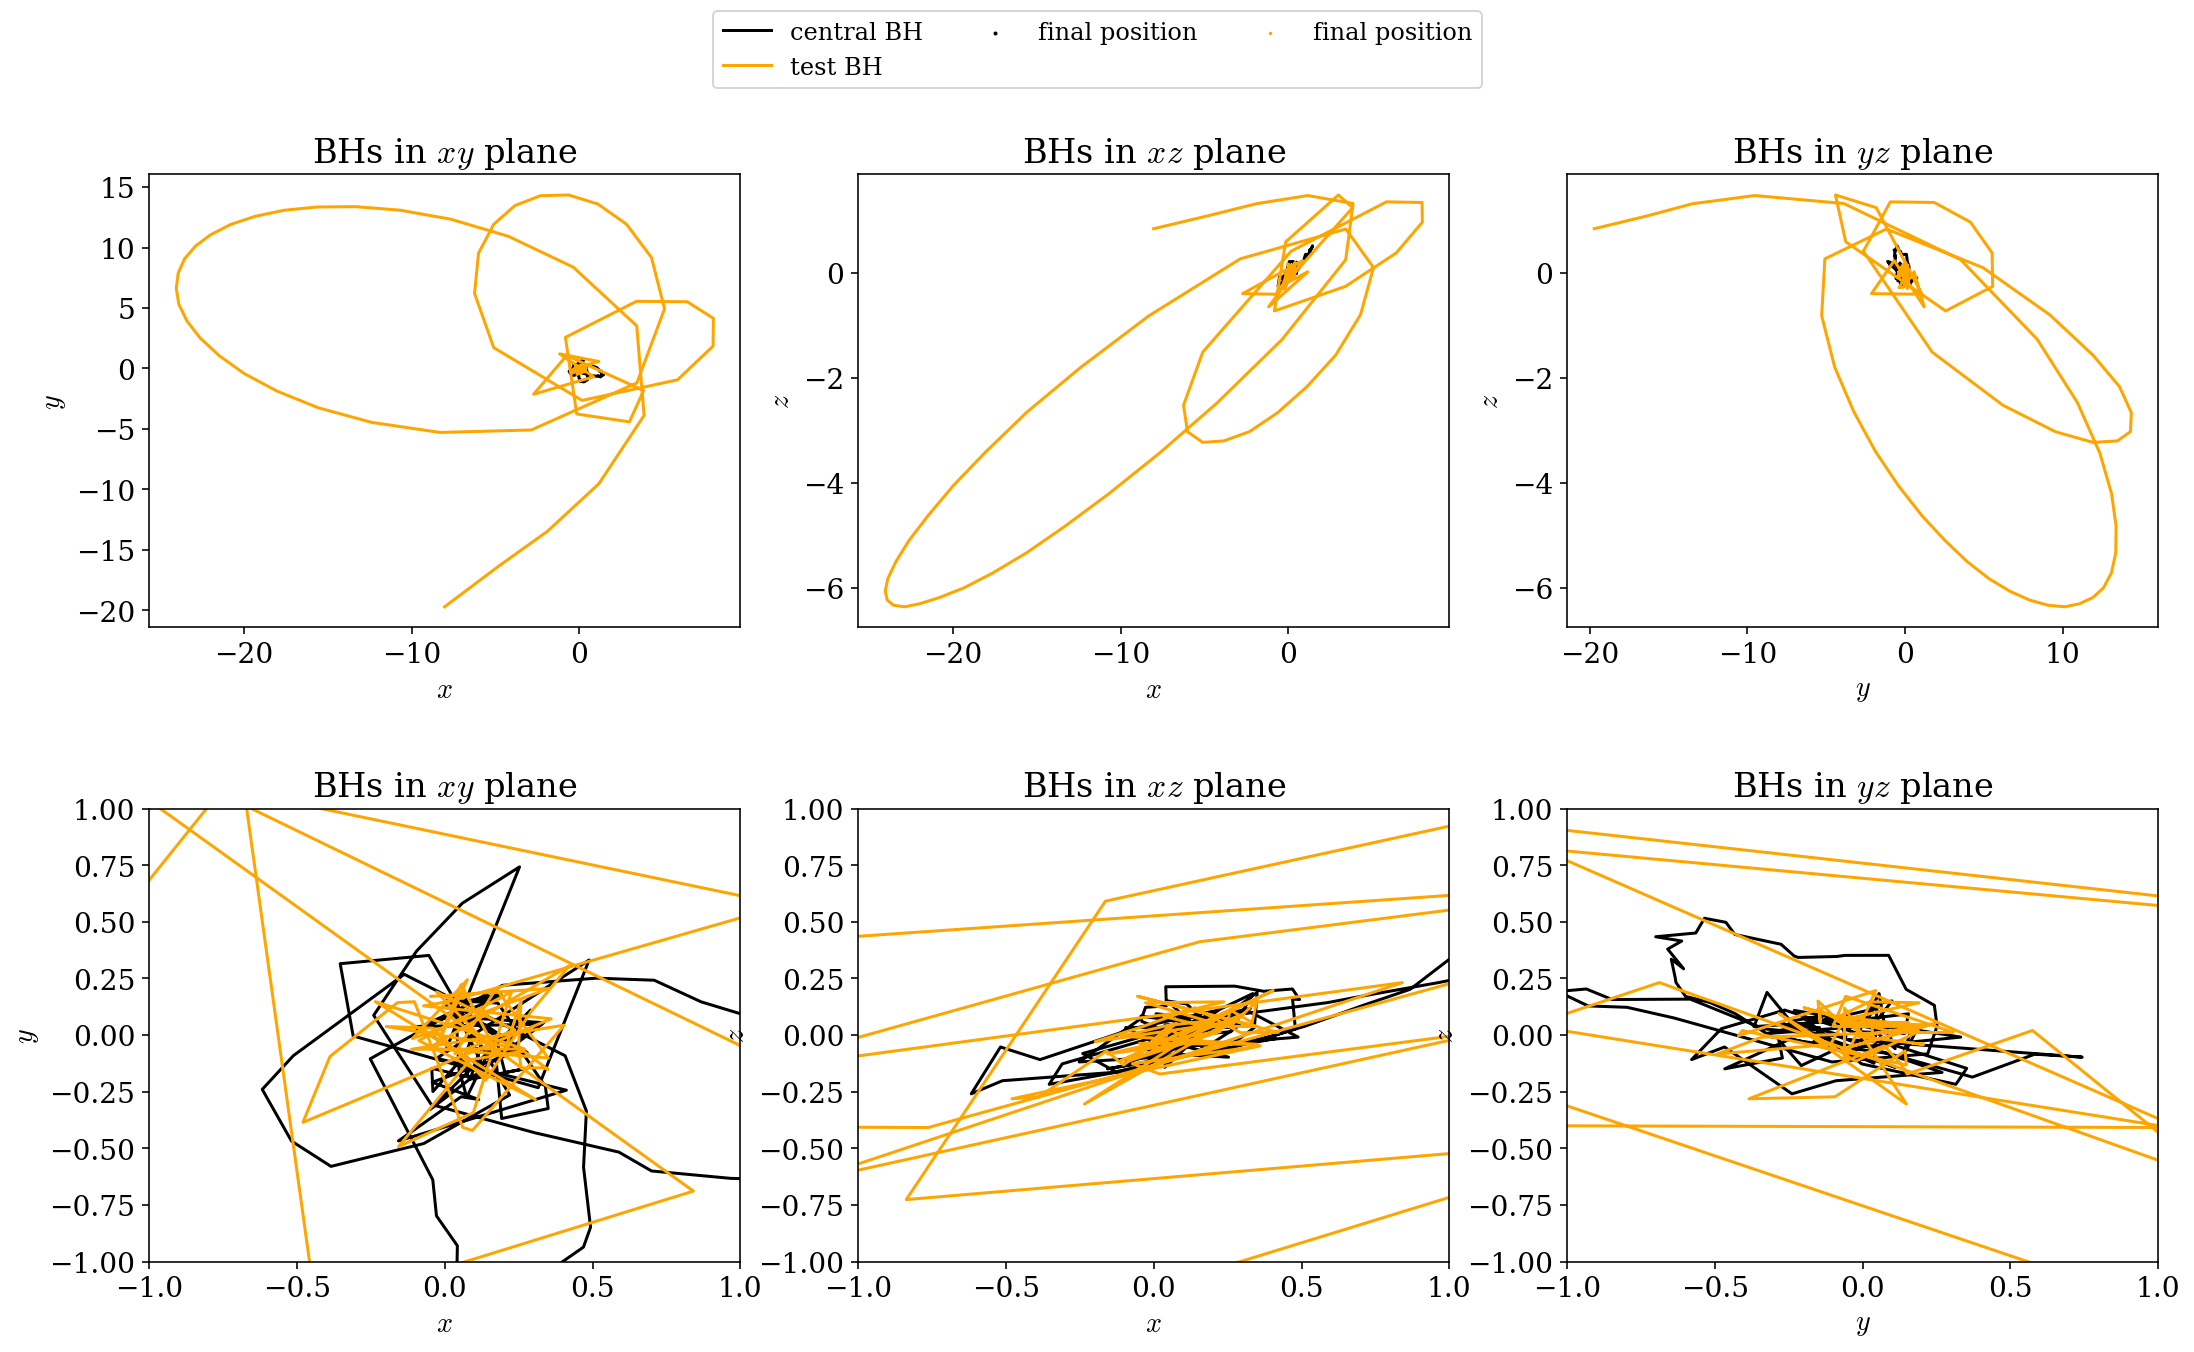

In [221]:
fig,ax = plt.subplots(figsize=(18,10),nrows=2,ncols=3)
fig.subplots_adjust(hspace=0.4) 


ax[0,0].plot(x_sim_COM[:,0],y_sim_COM[:,0],color='black', label='central BH')
ax[0,0].plot(x_sim_COM[:,1],y_sim_COM[:,1],color='orange', label='test BH')
ax[0,0].scatter(x_sim_COM[-1,0],y_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[0,0].scatter(x_sim_COM[-1,1],y_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[0,0].set_title(r'BHs in $xy$ plane')
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$y$')
#ax[0,0].legend(loc='best', fontsize=10)

ax[0,1].plot(x_sim_COM[:,0],z_sim_COM[:,0],color='black', label='central BH')
ax[0,1].plot(x_sim_COM[:,1],z_sim_COM[:,1],color='orange', label='test BH')
ax[0,1].scatter(x_sim_COM[-1,0],z_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[0,1].scatter(x_sim_COM[-1,1],z_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[0,1].set_title(r'BHs in $xz$ plane')
ax[0,1].set_xlabel(r'$x$')
ax[0,1].set_ylabel(r'$z$')
#ax[0,1].legend(loc='best', fontsize=10)

ax[0,2].plot(y_sim_COM[:,0],z_sim_COM[:,0],color='black', label='central BH')
ax[0,2].plot(y_sim_COM[:,1],z_sim_COM[:,1],color='orange', label='test BH')
ax[0,2].scatter(y_sim_COM[-1,0],z_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[0,2].scatter(y_sim_COM[-1,1],z_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[0,2].set_title(r'BHs in $yz$ plane')
ax[0,2].set_xlabel(r'$y$')
ax[0,2].set_ylabel(r'$z$')
#ax[0,2].legend(loc='best', fontsize=10)

ax[1,0].plot(x_sim_COM[:,0],y_sim_COM[:,0],color='black', label='central BH')
ax[1,0].plot(x_sim_COM[:,1],y_sim_COM[:,1],color='orange', label='test BH')
ax[1,0].scatter(x_sim_COM[-1,0],y_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[1,0].scatter(x_sim_COM[-1,1],y_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[1,0].set_title(r'BHs in $xy$ plane')
ax[1,0].set_xlabel(r'$x$')
ax[1,0].set_ylabel(r'$y$')
ax[1,0].set_xlim(-1, +1)
ax[1,0].set_ylim(-1, +1)
#ax[1,0].legend(loc='best', fontsize=10)

ax[1,1].plot(x_sim_COM[:,0],z_sim_COM[:,0],color='black', label='central BH')
ax[1,1].plot(x_sim_COM[:,1],z_sim_COM[:,1],color='orange', label='test BH')
ax[1,1].scatter(x_sim_COM[-1,0],z_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[1,1].scatter(x_sim_COM[-1,1],z_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[1,1].set_title(r'BHs in $xz$ plane')
ax[1,1].set_xlabel(r'$x$')
ax[1,1].set_ylabel(r'$z$')
ax[1,1].set_xlim(-1, +1)
ax[1,1].set_ylim(-1, +1)
#ax[1,1].legend(loc='best', fontsize=10)


ax[1,2].plot(y_sim_COM[:,0],z_sim_COM[:,0],color='black', label='central BH')
ax[1,2].plot(y_sim_COM[:,1],z_sim_COM[:,1],color='orange', label='test BH')
ax[1,2].scatter(y_sim_COM[-1,0],z_sim_COM[-1,0],color='black',label='final position', s = 1)
ax[1,2].scatter(y_sim_COM[-1,1],z_sim_COM[-1,1],color='orange',label='final position', s = 0.5)
ax[1,2].set_title(r'BHs in $yz$ plane')
ax[1,2].set_xlabel(r'$y$')
ax[1,2].set_ylabel(r'$z$')
ax[1,2].set_xlim(-1, +1)
ax[1,2].set_ylim(-1, +1)
#ax[1,2].legend(loc='best', fontsize=10)


handles, labels = ax[0, 0].get_legend_handles_labels()

# Add a global legend above the plots
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

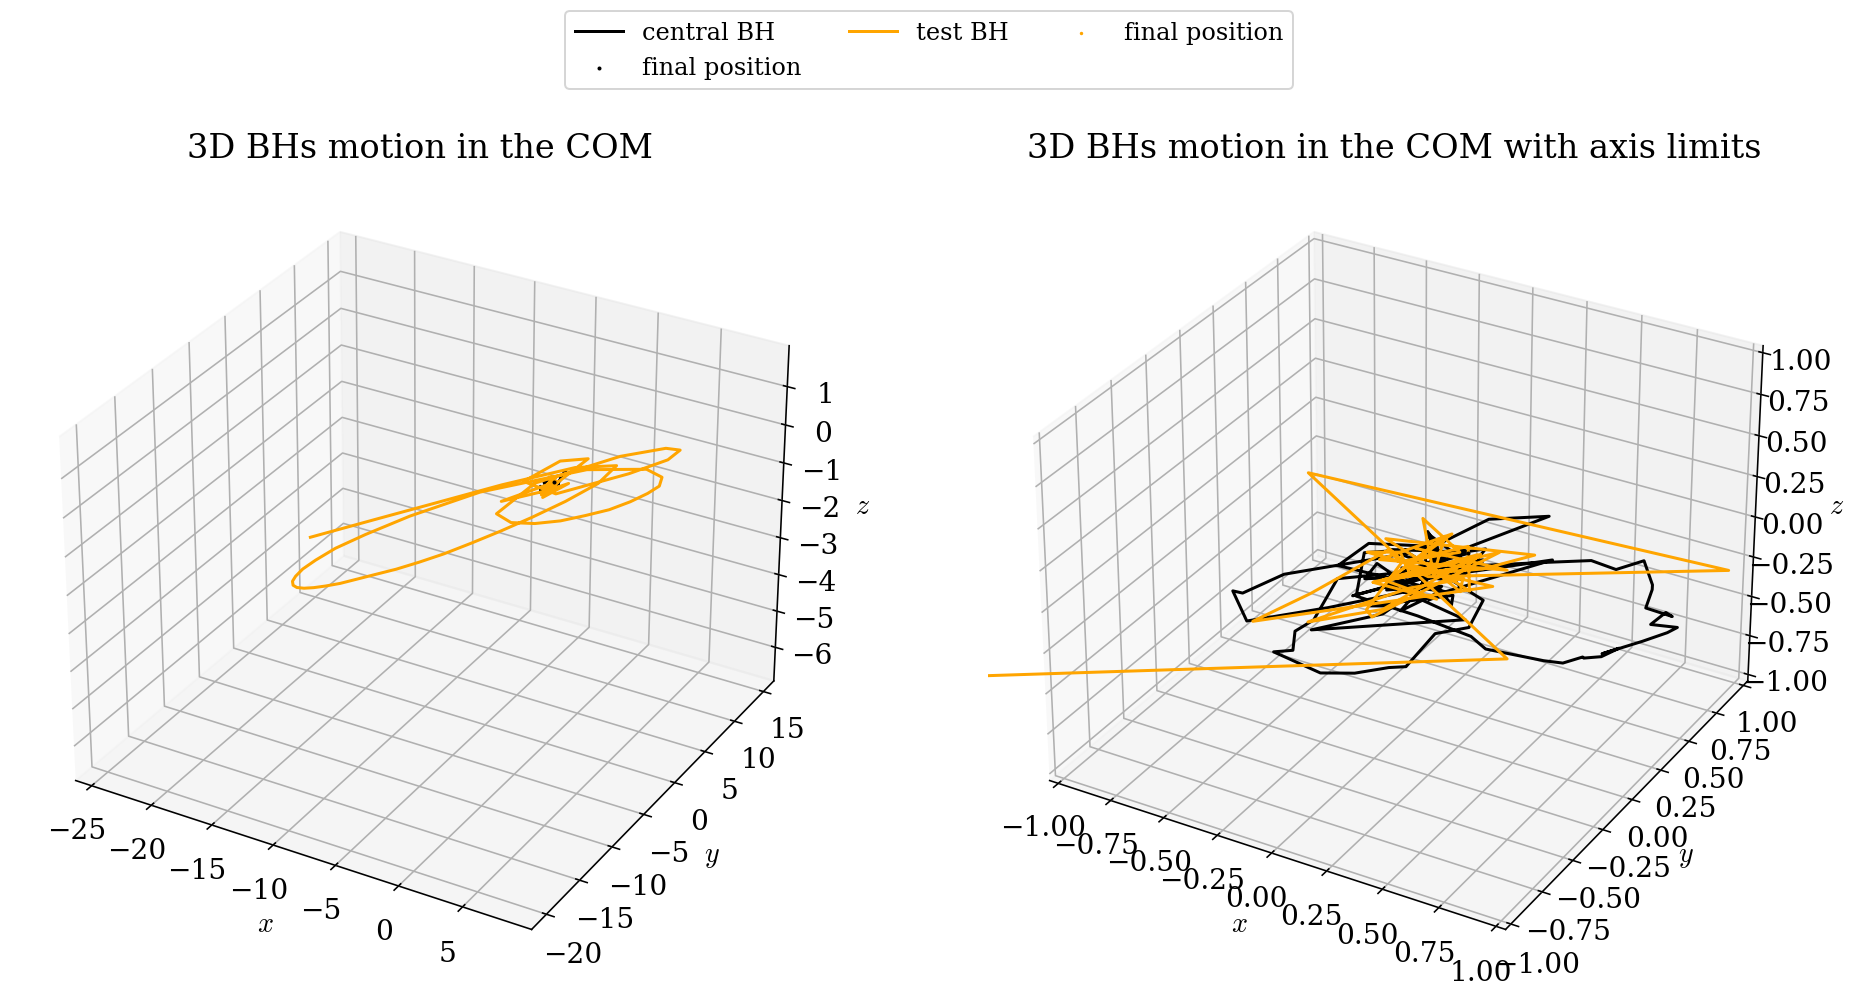

In [222]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})


ax[0].plot(x_sim_COM[:,0], y_sim_COM[:,0], z_sim_COM[:,0], color='black', label='central BH')
ax[0].scatter(x_sim_COM[-1,0], y_sim_COM[-1,0], z_sim_COM[-1,0], color='black', label='final position', s=1)
ax[0].plot(x_sim_COM[:,1], y_sim_COM[:,1], z_sim_COM[:,1], color='orange', label='test BH')
ax[0].scatter(x_sim_COM[-1,1], y_sim_COM[-1,1], z_sim_COM[-1,1], color='orange', label='final position', s=0.5)
ax[0].set_title('3D BHs motion in the COM')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_zlabel(r'$z$')

ax[1].plot(x_sim_COM[:,0], y_sim_COM[:,0], z_sim_COM[:,0], color='black', label='central BH')
ax[1].scatter(x_sim_COM[-1,0], y_sim_COM[-1,0], z_sim_COM[-1,0], color='black', label='final position', s=1)

# We only plot the trajectory of the 'test' BH constrained in thie region
ax[1].plot(x_sim_COM[53:,1], y_sim_COM[53:,1], z_sim_COM[53:,1], color='orange', label='test BH')
ax[1].scatter(x_sim_COM[-1,1], y_sim_COM[-1,1], z_sim_COM[-1,1], color='orange', label='final position', s=0.5)
ax[1].set_title('3D BHs motion in the COM with axis limits')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')
ax[1].set_zlabel(r'$z$')


ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_zlim(-1, 1)

handles, labels = ax[0].get_legend_handles_labels()

# Add a global legend above the plots
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

### Relative distance of the two BHs

We are supposing that these 2 particles are BH, even though they are point particle we computer the associated **Schwarzschild radius** of that BH:

$$
R_S =  \frac{2 G}{c^2} M  \,.
$$

We need to rember that we are using internal units:

$$ 1 \, r_{iu} = 1\,  kpc = 3 \cdot 10^{21} \,cm $$
$$ 1 \, m_{iu} = 10^{8}\,  M\odot = 2 \cdot 10^{41}\, g $$
$$ 1 \, v_{iu} = 20.55 \, km/s .$$

In [230]:
# PU = physical units    IU = internal units

c_PU = const.c.value #[m/s]
G_PU = const.G.value # [m^3/kg s^2]
G_IU = 1.0
M_sun_PU = const.M_sun.value # [kg]

M_BH_central_PU = 10**9 * const.M_sun.value  # [kg], mass of the central SMBH 10^9 Msun
M_BH_df_PU = 5*(10**8) * const.M_sun.value # [kg], BH where to study the dynamical friction

R_S_BHcen_PU = 2*G_PU*M_BH_central_PU / c_PU**2 # Schwarzschild radius of the central BH in physical units
R_S_BHdf_PU = 2*G_PU*M_BH_df_PU / c_PU**2 # Schwarzschild radius of the 'test' BH in physical units

m_to_pc = 3.24078e-17 # 1 m in parsec 
R_S_BHcen_IU = R_S_BHcen_PU * m_to_pc
R_S_BHdf_IU = R_S_BHdf_PU * m_to_pc

In [231]:
print('Schwarzschild radius of the central BH [m]: {:.2e}'.format(R_S_BHcen_PU))
print('Schwarzschild radius of the test BH [m] : {:.2e}'.format(R_S_BHdf_PU))
print('Schwarzschild radius of the central BH [IU]: {:.2e}'.format(R_S_BHcen_IU))
print('Schwarzschild radius of the test BH [IU] : {:.2e}'.format(R_S_BHdf_IU))

Schwarzschild radius of the central BH [m]: 2.95e+12
Schwarzschild radius of the test BH [m] : 1.48e+12
Schwarzschild radius of the central BH [IU]: 9.57e-05
Schwarzschild radius of the test BH [IU] : 4.79e-05


In [232]:
dsep_COM = np.empty([len(t_sim)])

for i in range(len(t_sim)): 
    dsep_COM[i] = abs(r_sim_COM[i][1]-r_sim_COM[i][0])
        

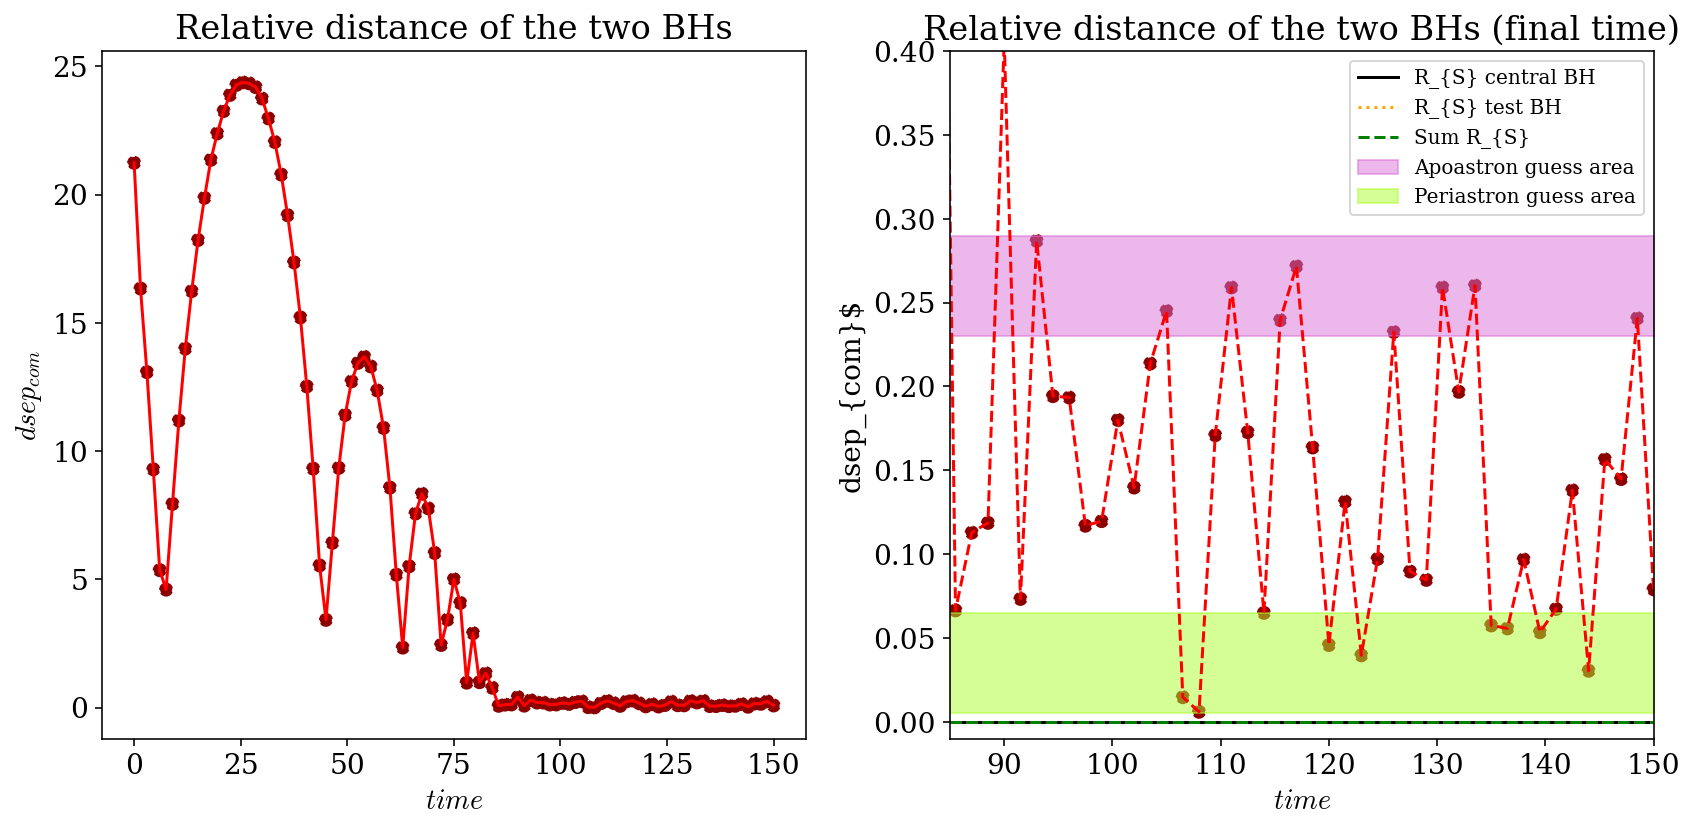

In [242]:
fig,ax = plt.subplots(figsize=(12,6),nrows=1,ncols=2)


ax[0].plot(t_sim,dsep_COM,c='red')
ax[0].scatter(t_sim,dsep_COM,c='darkred', linestyle = '--')
ax[0].set_xlabel(r'$time$')
ax[0].set_ylabel(r'$dsep_{com}$')
ax[0].set_title(r'Relative distance of the two BHs')
#ax[0].legend(loc='best', fontsize=10)

ax[1].plot(t_sim,dsep_COM,c='red', linestyle = '--')
ax[1].scatter(t_sim,dsep_COM,c='darkred', linestyle = '--')
#ax[1].axhline( np.mean(dsep_COM[60:]), color = 'green', label = 'mean value')
ax[1].axhline( R_S_BHcen_IU, color = 'black', label = 'R_{S} central BH')
ax[1].axhline( R_S_BHdf_IU, color = 'orange', label = 'R_{S} test BH', linestyle=':')
ax[1].axhline( R_S_BHcen_IU+R_S_BHdf_IU, color = 'green', label = 'Sum R_{S}', linestyle='--')
ax[1].fill_between(t_sim, 0.23, 0.29, color='orchid', alpha=0.5, label='Apoastron guess area')
ax[1].fill_between(t_sim, 0.005, 0.065, color='greenyellow', alpha=0.5, label='Periastron guess area')


ax[1].set_title(r'Relative distance of the two BHs (final time)')
ax[1].set_xlabel(r'$time$')
ax[1].set_ylabel(r'dsep_{com}$')
ax[1].set_xlim(85, t_sim[-1])
ax[1].set_ylim(-0.01, 0.4)
ax[1].legend(loc='best', fontsize=10)

fig.tight_layout()

In [234]:
print('minimum distance : {:.2e}'.format(np.min(dsep_COM)))
print('Sum of the two Schwarzschild radius: {:.2e}'.format(R_S_BHcen_IU+R_S_BHdf_IU))

minimum distance : 5.99e-03
Sum of the two Schwarzschild radius: 1.44e-04


Their distance is 1 order of magnitude greater than the Sum of their hypothetical Schwarzschild radius $ R_{S} $. They are not so near the merger phase. After a certain time, time ~ 90, they seems to form a binary system wihtout a significant reduction of the distance of the two object, has we had before, probably due the intercation eith the Herquinst distribution particle. We are interpretating these two particle has two BH, but for the simulation they are just particles, so there is not loss of energy, or the shrink of the obrits neither due the emission of GWs.

The point of the plot above represents the value of the distance of the two BHs at a certain time, I try to prppose a range for the position of the periastron and the apoastron, but it's just a guess, 

From a theoretycal point of view, we are modelling in a simplified way, using the treecode, the formation of a **M**assive **B**lack **H**ole **B**inary. We can state that MBHB are formed after the hierarchical mergers of galaxy, we simplify this situation considering only a MBH in a galaxy with a MBHB, avoiding to treat two galaxies.

Here it is a scheme about the formation and the merger of two MBHs:

1. dynamical friction: kpc $ \rightarrow $  pc, at dsep ~ 1 pc the dynamics is dominated by the other BH
2. binary hardening: pc  $ \rightarrow $ mpc
3. GWs emission: mpc  $ \rightarrow $ merger


### Angular Momentum

In [244]:
pos_vector_COM = np.array([x_sim_COM,y_sim_COM,z_sim_COM]).T # transpose for calculation reasons
vel_vector_COM = np.array([Vx_sim_COM,Vy_sim_COM,Vz_sim_COM]).T

# angular momentum in the COM
L_COM = np.empty([len(t_sim), N_tot, 3])

for i in tqdm(range(len(t_sim))):
    for j in range(N_tot):
        L_COM[i,j] = masses[i,j]*np.cross(pos_vector_COM[j,i],vel_vector_COM[j,i])

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:48<00:00,  2.06it/s]


In [270]:
# Hernquist
Lx_H_COM = np.zeros(len(t_sim))
Ly_H_COM = np.zeros(len(t_sim))
Lz_H_COM = np.zeros(len(t_sim))

# central BH
Lx_BH_cen_COM = np.zeros(len(t_sim))
Ly_BH_cen_COM = np.zeros(len(t_sim))
Lz_BH_cen_COM = np.zeros(len(t_sim))

# 'test' BH
Lx_BH_df_COM = np.zeros(len(t_sim))
Ly_BH_df_COM = np.zeros(len(t_sim))
Lz_BH_df_COM = np.zeros(len(t_sim))


for i in range(len(t_sim)):
    Lx_BH_cen_COM[i] = L_COM[i,0,0]
    Ly_BH_cen_COM[i] = L_COM[i,0,1]
    Lz_BH_cen_COM[i] = L_COM[i,0,2]
    
    Lx_BH_df_COM[i] = L_COM[i,1,0]
    Ly_BH_df_COM[i] = L_COM[i,1,1]
    Lz_BH_df_COM[i] = L_COM[i,1,2]
    
    Lx_H_COM[i] = np.sum(L_COM[i,2:,0])
    Ly_H_COM[i] = np.sum(L_COM[i,2:,1])
    Lz_H_COM[i] = np.sum(L_COM[i,2:,2])
    

L_tot_BH_cen_COM = np.sqrt(Lx_BH_cen_COM**2+Ly_BH_cen_COM**2+Lz_BH_cen_COM**2)
L_tot_BH_df_COM = np.sqrt(Lx_BH_df_COM**2+Ly_BH_df_COM**2+Lz_BH_df_COM**2)
L_tot_H_COM = np.sqrt(Lx_H_COM**2+Ly_H_COM**2+Lz_H_COM**2)

#### Central BH

Text(0, 0.5, '$L_z$')

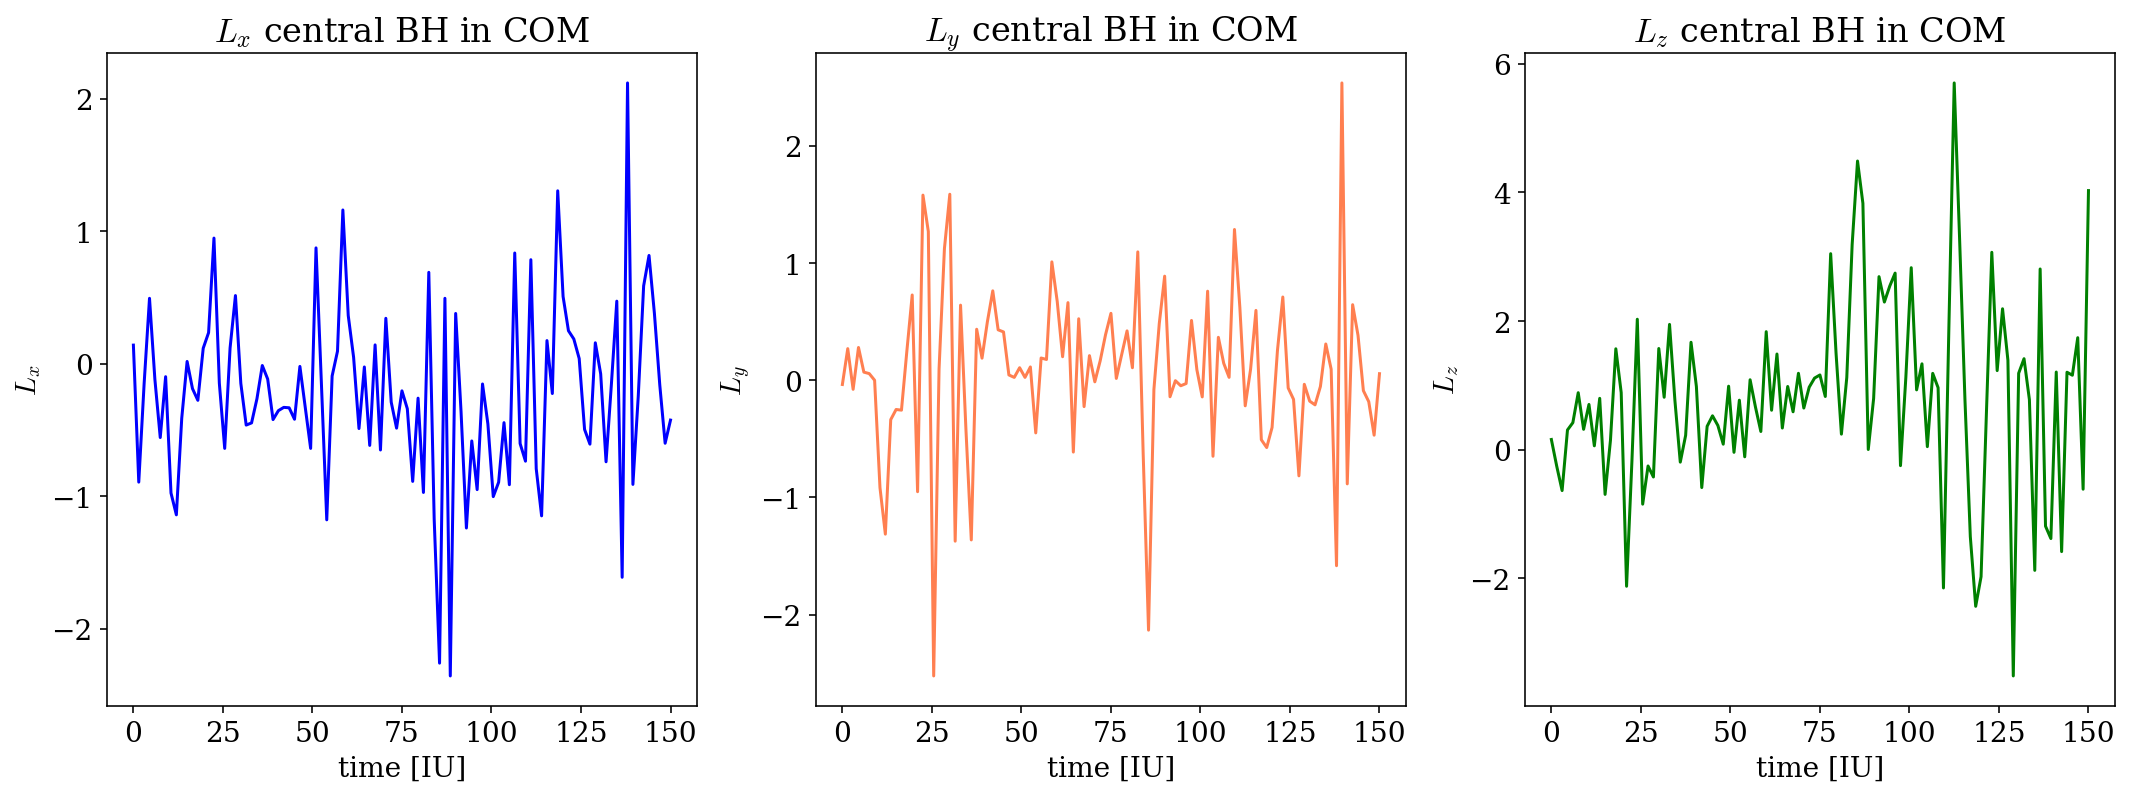

In [271]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,6))

ax[0].plot(t_sim,Lx_BH_cen_COM,label=r'$L_x$',color='blue')
ax[0].set_title(r'$L_x$ central BH in COM')
ax[0].set_xlabel('time [IU]')
ax[0].set_ylabel(r'$L_x$')
ax[1].plot(t_sim,Ly_BH_cen_COM,label=r'$L_y$',color='coral')
ax[1].set_title(r'$L_y$ central BH in COM')
ax[1].set_xlabel('time [IU]')
ax[1].set_ylabel(r'$L_y$')
ax[2].plot(t_sim,Lz_BH_cen_COM,label=r'$L_z$',color='green')
ax[2].set_title(r'$L_z$ central BH in COM')
ax[2].set_xlabel('time [IU]')
ax[2].set_ylabel(r'$L_z$')

Text(0.5, 1.0, '$L_{tot}$ central BH in the COM')

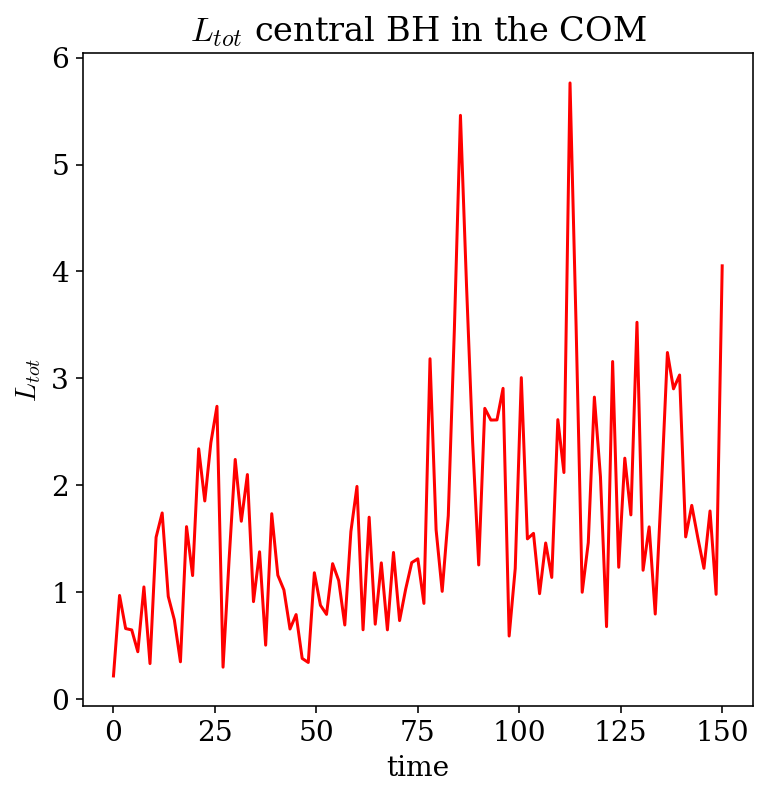

In [272]:
fig = plt.subplots(figsize=(6,6))

plt.plot(t_sim,L_tot_BH_cen_COM,c='red')
plt.xlabel('time')
plt.ylabel(r'$L_{tot}$')
plt.title(r'$L_{tot}$ central BH in the COM')

####  'test' BH 

Text(0, 0.5, '$L_z$')

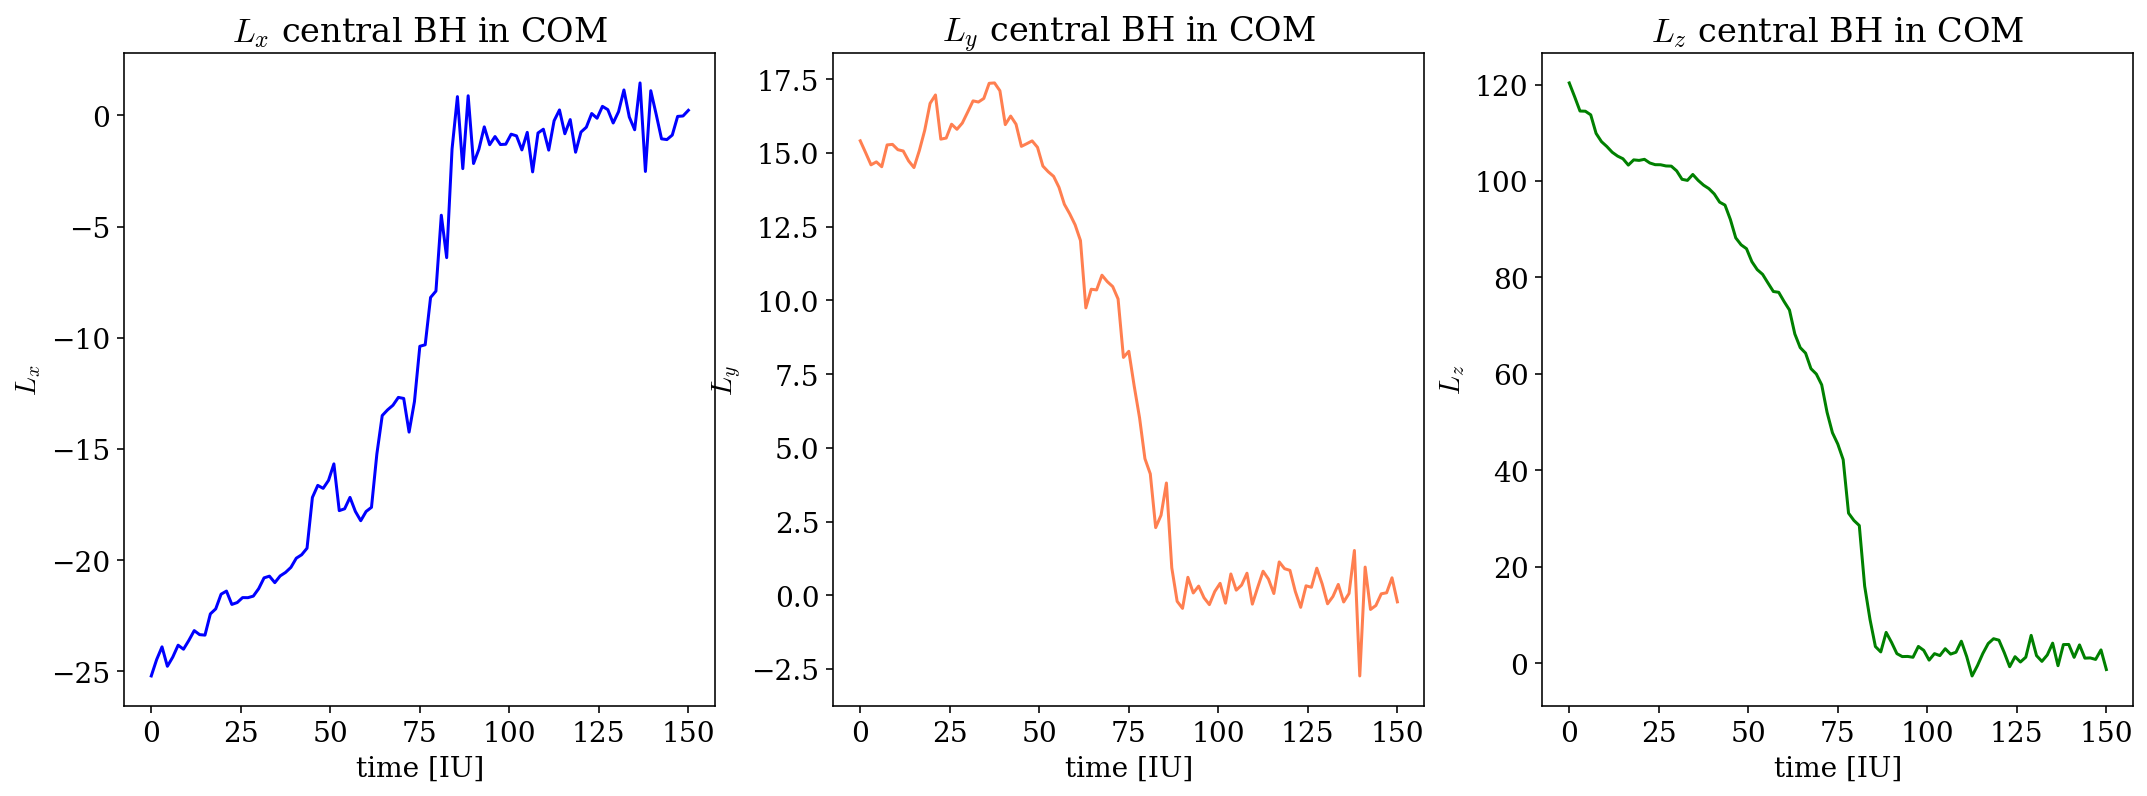

In [273]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,6))

ax[0].plot(t_sim,Lx_BH_df_COM,label=r'$L_x$',color='blue')
ax[0].set_title(r'$L_x$ central BH in COM')
ax[0].set_xlabel('time [IU]')
ax[0].set_ylabel(r'$L_x$')
ax[1].plot(t_sim,Ly_BH_df_COM,label=r'$L_y$',color='coral')
ax[1].set_title(r'$L_y$ central BH in COM')
ax[1].set_xlabel('time [IU]')
ax[1].set_ylabel(r'$L_y$')
ax[2].plot(t_sim,Lz_BH_df_COM,label=r'$L_z$',color='green')
ax[2].set_title(r'$L_z$ central BH in COM')
ax[2].set_xlabel('time [IU]')
ax[2].set_ylabel(r'$L_z$')

Text(0.5, 1.0, '$L_{tot}$ central BH in the COM')

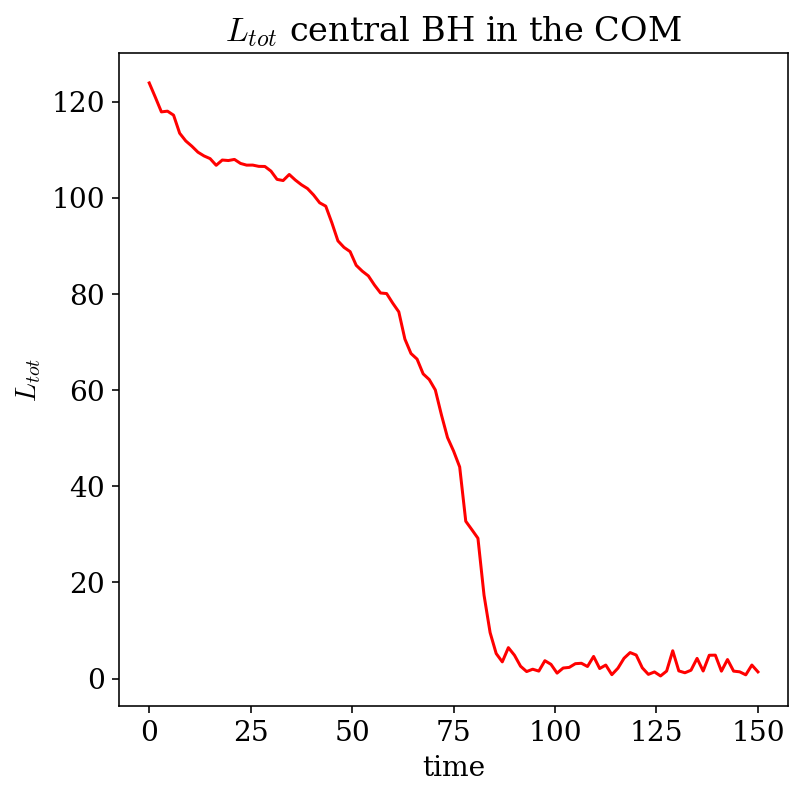

In [274]:
fig = plt.subplots(figsize=(6,6))

plt.plot(t_sim,L_tot_BH_df_COM,c='red')
plt.xlabel('time')
plt.ylabel(r'$L_{tot}$')
plt.title(r'$L_{tot}$ central BH in the COM')

#### Hernquist 

Text(0, 0.5, '$L_z$')

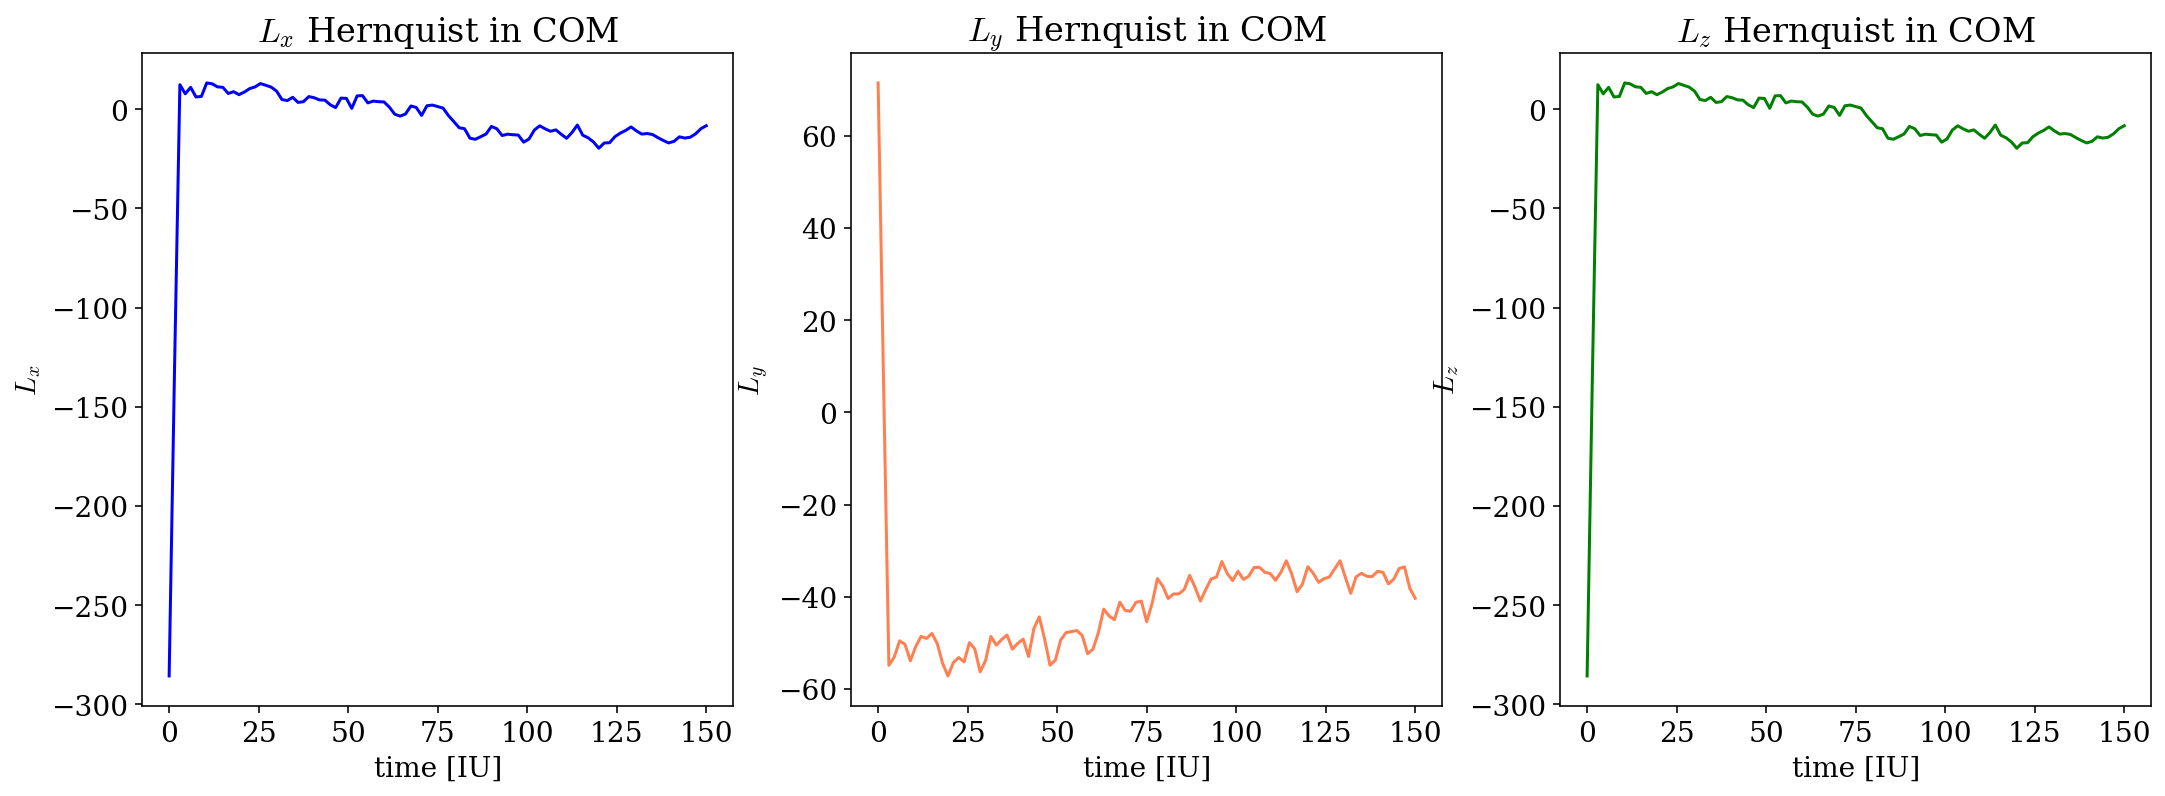

In [275]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,6))

ax[0].plot(t_sim,Lx_H_COM,label=r'$L_x$',color='blue')
ax[0].set_title(r'$L_x$ Hernquist in COM')
ax[0].set_xlabel('time [IU]')
ax[0].set_ylabel(r'$L_x$')
ax[1].plot(t_sim,Ly_H_COM,label=r'$L_y$',color='coral')
ax[1].set_title(r'$L_y$ Hernquist in COM')
ax[1].set_xlabel('time [IU]')
ax[1].set_ylabel(r'$L_y$')
ax[2].plot(t_sim,Lx_H_COM,label=r'$L_z$',color='green')
ax[2].set_title(r'$L_z$ Hernquist in COM')
ax[2].set_xlabel('time [IU]')
ax[2].set_ylabel(r'$L_z$')

(40.0, 120.0)

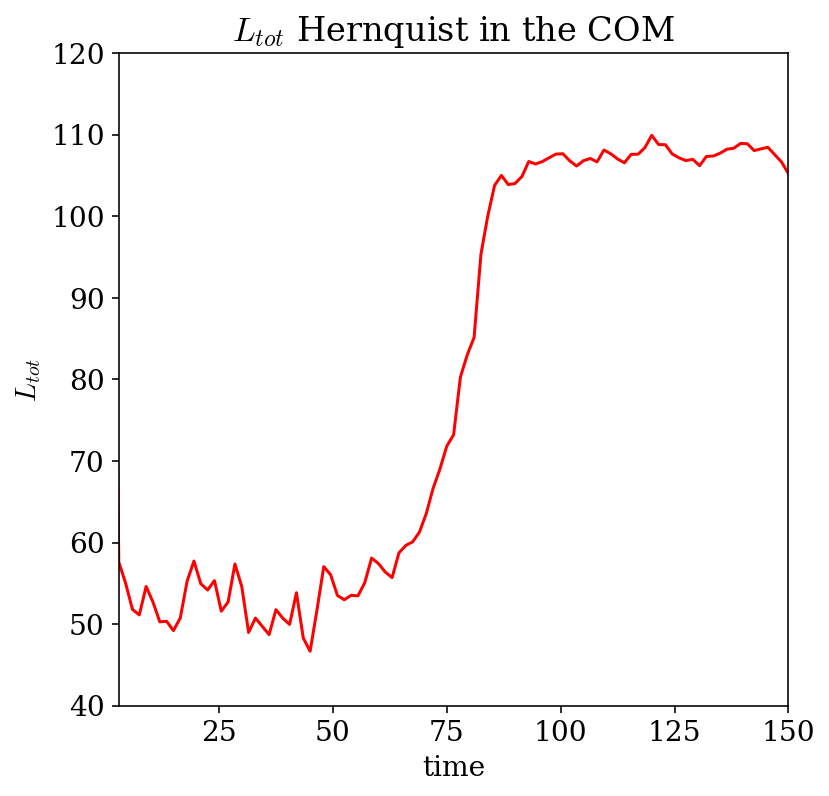

In [282]:
fig = plt.subplots(figsize=(6,6))

plt.plot(t_sim,L_tot_H_COM,c='red')
plt.xlabel('time')
plt.ylabel(r'$L_{tot}$')
plt.title(r'$L_{tot}$ Hernquist in the COM')
plt.xlim(3,t_sim[-1])
plt.ylim(40,120)